# Projet IPEO

### Data loading

Loading the require librairies

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader

## First part - training with 2 models to see which one perform better

/home/calvo/IPEO_production/scitas_venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  Mean: [0.3520651161670685, 0.38347339630126953, 0.2852245569229126]
  Std:  [0.14353740215301514, 0.12388759851455688, 0.12524263560771942]
Used device : cuda
Classes : ['damage', 'no_damage']
Number of images (train) : 19000
Number of images (val) : 2000
Number of images (test) : 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4809666..4.673837].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3989398..4.235472].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7763876..3.9536664].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0823975..1.2295424].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.050743..1.7273191].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8291633..5.5505667].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1140516..1.781961].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1140516..3.0139365].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7025462..3.7971077].


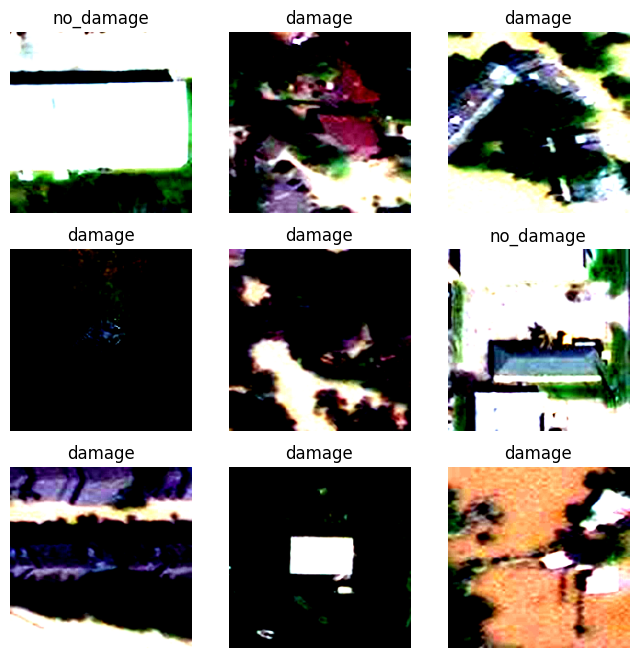

In [2]:
from data_utils import compute_normalization_stats

base_dir = "ipeo_hurricane_for_students"

#Compute normalization statistics from training set using the function defined in data_utils.py
mean, std = compute_normalization_stats(base_dir, split="train")

#Define normalization transform using computed mean and std from training set
normalize = T.Normalize(mean, std)

#Define default transform for datasets with the good size for model and normalization
default_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])

#Load datasets with defined transform
train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=default_transform)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=default_transform)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=default_transform)

#Detection of device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Used device :", device)


# DataLoader configuration
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=2)

#Print dataset information
print("Classes :", train_ds.classes)
print("Number of images (train) :", len(train_ds))
print("Number of images (val) :", len(val_ds))
print("Number of images (test) :", len(test_ds))

#Function to display a batch of images from a DataLoader
def show_batch(loader):
    """Display a batch of images from the given DataLoader"""
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)

### Model loading

In [3]:
#Using 2 deep learning modele, resnet34 and mobilenet_v3_small
from torchvision.models import resnet34, mobilenet_v3_small

#load a resnet34 with 2 classes (damage vs no_damage) and move to device
model_resnet = resnet34(num_classes=2).to(device)
model_resnet #Visualize model architecture

#load a mobilnet_v3_small with 2 classes (damage vs no_damage) and move to device
model_mobilenet = mobilenet_v3_small(num_classes=2).to(device)
model_mobilenet #Visualize model architecture

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Loss function with class balancing

In [4]:
#Compute class weights to handle imbalanced dataset
from collections import Counter
from torch.nn import CrossEntropyLoss

def compute_class_weights(dataset, device):
    """Derive the weight of each class"""
    #Count the occurence of each class (damage or no_damange)
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    
    #Derive the weight of each class
    total_samples = len(labels)
    num_classes = len(class_counts)
    class_weights = torch.zeros(num_classes)
    
    for class_id, count in class_counts.items():
        class_weights[class_id] = total_samples / (num_classes * count)
    
    return class_weights.to(device)

#Derive the weight of the class on the training dataset 
class_weights = compute_class_weights(train_ds, device)

#Display the weight of each class
for i, weight in enumerate(class_weights):
    print(f"Class {train_ds.classes[i]}: {weight:.4f}")

#Define the loss function with class weights using CrossEntropyLoss
criterion = CrossEntropyLoss(weight=class_weights)

Class damage: 0.7308
Class no_damage: 1.5833


### Optimizer

In [5]:
from torch.optim import SGD

#Define optimizer hyperparameters (learning rate and weight decay for regularization)
learning_rate = 0.01
weight_decay = 1e-4   

optimizer_resnet = SGD(model_resnet.parameters(),lr=learning_rate,weight_decay=weight_decay)
optimizer_mobilenet = SGD(model_mobilenet.parameters(),lr=learning_rate,weight_decay=weight_decay)

### Training step

In [6]:
#Using training step function from in class exercices (with a few modifications)
def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)

### Training and validating over the full batch

In [7]:
#Using training function from in class exercices (with a few modifications)
def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []
    #get total number of batches to see progress
    total_batches = len(train_dl)
    print(f"Training: {total_batches} batches to process")

    for batch_idx, batch in enumerate(train_dl, 1):
        loss, accuracy = training_step(batch, model, optimizer, device)

        # append statistics
        losses.append(loss) 
        accuracies.append(accuracy)
        
        #print progress every 10 batches to see progression 
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"  Batch {batch_idx}/{total_batches} - loss: {loss:.4f}, acc: {accuracy*100:.2f}%")

    #if the list is empty (no batches), return 0
    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def prediction_step(unseen_dl, model, device):
    """Evaluate the model on the validation or test set (similar to prediction_step from in class exercices)"""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  #no gradient for validation
        for batch in unseen_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    #if the list is empty (no batches), return 0
    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))

Training of both models

In [8]:
num_epochs = 50  #Long training with 50 epochs with early stopping

#create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

#early stopping configuration
patience = 10  #number of epochs without improvement before stopping
min_delta = 0.001  #minimum improvement considered (0.1%)

#check if models and stats exist to skip training (to avoid long re-training)
models_exist = (os.path.exists("models/mobilenet_test.pth") and 
                os.path.exists("models/resnet_test.pth") and 
                os.path.exists("models/stats_test.json"))

if models_exist:
    #open models (map_location for CPU/GPU compatibility)
    model_mobilenet.load_state_dict(torch.load("models/mobilenet_test.pth", map_location=device))
    model_resnet.load_state_dict(torch.load("models/resnet_test.pth", map_location=device))
    
    #open stats
    with open("models/stats_test.json", "r") as f:
        saved_stats = json.load(f)
        stats_mobilenet = saved_stats["mobilenet"]
        stats_resnet = saved_stats["resnet"]
    train_models = False
else:
    train_models = True

#Training only if models do not already exist
if train_models:
    #Training of Mobilenet with early stopping
    stats_mobilenet = []
    best_val_acc_mobilenet = 0
    patience_counter_mobilenet = 0
    
    for epoch in range(num_epochs):
        print(f"Mobilenet - Epoch {epoch+1}/{num_epochs}") #Print epoch number to see progression
        #training and validation steps
        trainloss_mobilenet, trainaccuracy_mobilenet = train_epoch(train_loader, model_mobilenet, optimizer_mobilenet, device)
        valloss_mobilenet, valaccuracy_mobilenet = prediction_step(val_loader, model_mobilenet, device)

        #Visualize training/validation loss and accuracy for each epoch
        print(f"epoch {epoch}; trainloss {trainloss_mobilenet:.4f}, train accuracy {trainaccuracy_mobilenet*100:.2f}% | valloss {valloss_mobilenet:.4f}, val accuracy {valaccuracy_mobilenet*100:.2f}%")

        #Save stats for this epoch
        stats_mobilenet.append({
            "trainloss": float(trainloss_mobilenet),
            "trainaccuracy": float(trainaccuracy_mobilenet),
            "valloss": float(valloss_mobilenet),
            "valaccuracy": float(valaccuracy_mobilenet),
            "epoch": epoch
        })

        #Early stopping implementation
        if valaccuracy_mobilenet > best_val_acc_mobilenet + min_delta:
            best_val_acc_mobilenet = valaccuracy_mobilenet
            patience_counter_mobilenet = 0
            #Save best model
            torch.save(model_mobilenet.state_dict(), "models/mobilenet_test.pth")
        else:
            patience_counter_mobilenet += 1
            print(f"No improvement, patience: {patience_counter_mobilenet}/{patience}") #print patience status
            
            if patience_counter_mobilenet >= patience: #if patience exceeded, stop training => early stopping
                print(f"Best validation accuracy: {best_val_acc_mobilenet*100:.2f}%")
                break

    #Training of Resnet with early stopping
    stats_resnet = []
    best_val_acc_resnet = 0
    patience_counter_resnet = 0
    
    for epoch in range(num_epochs):
        print(f"Resnet - Epoch {epoch+1}/{num_epochs}") #Print epoch number to see progression
        #training and validation steps
        trainloss_resnet, trainaccuracy_resnet = train_epoch(train_loader, model_resnet, optimizer_resnet, device)
        valloss_resnet, valaccuracy_resnet = prediction_step(val_loader, model_resnet, device)

        #Visualize training/validation loss and accuracy for each epoch
        print(f"epoch {epoch}; trainloss {trainloss_resnet:.4f}, train accuracy {trainaccuracy_resnet*100:.2f}% | valloss {valloss_resnet:.4f}, val accuracy {valaccuracy_resnet*100:.2f}%")

        stats_resnet.append({
            "trainloss": float(trainloss_resnet),
            "trainaccuracy": float(trainaccuracy_resnet),
            "valloss": float(valloss_resnet),
            "valaccuracy": float(valaccuracy_resnet),
            "epoch": epoch
        })

        #Early stopping implementation
        if valaccuracy_resnet > best_val_acc_resnet + min_delta:
            best_val_acc_resnet = valaccuracy_resnet
            patience_counter_resnet = 0
            #Save best model
            torch.save(model_resnet.state_dict(), "models/resnet_test.pth")
        else:
            patience_counter_resnet += 1
            print(f"No improvement, patience: {patience_counter_resnet}/{patience}") #print patience status
            
            if patience_counter_resnet >= patience: #if patience exceeded, stop training => early stopping
                print(f"Best validation accuracy: {best_val_acc_resnet*100:.2f}%") 
                break

    #Save stats as JSON
    with open("models/stats_test.json", "w") as f:
        json.dump({"mobilenet": stats_mobilenet, "resnet": stats_resnet}, f)
else:
    print("Training skipped, models and stats already exist") #if models and stats exist, skip training


/tmp/2766790/ipykernel_1717783/3116485970.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mobilenet.load_state_dict(torch.load("models/mobilenet_test.pth", map_lo

Training skipped, models and stats already exist


### Visualisation of training and validation losses and accuracies

Visualisation for mobilenet

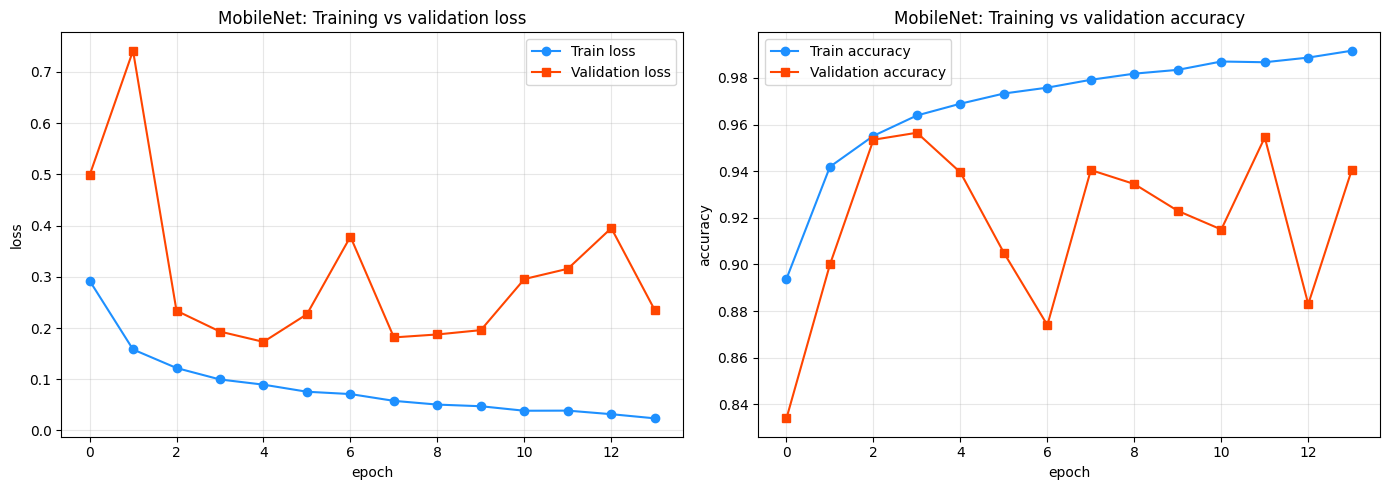

In [9]:
os.makedirs("outputs", exist_ok=True) #Create outputs directory if it doesn't exist
#Retrieve training stats for mobilenet
trainlosses = np.array([stat["trainloss"] for stat in stats_mobilenet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_mobilenet])
#Retrieve validation stats for mobilenet
vallosses = np.array([stat["valloss"] for stat in stats_mobilenet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_mobilenet])
#Retrieve epochs
epochs = np.array([stat["epoch"] for stat in stats_mobilenet])

#Plot training and validation curves for mobilenet with 2 subplots (loss and accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#Subplot 1 = loss (train and validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train loss', color='dodgerblue')
ax1.plot(epochs, vallosses, marker='s', label='Validation loss', color='orangered')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("MobileNet: Training vs validation loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

#Subplot 2 = accuracy (train and validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train accuracy', color='dodgerblue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation accuracy', color='orangered')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("MobileNet: Training vs validation accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/mobilenet_training_curves.png", dpi=150, bbox_inches='tight') #Save figure
plt.show()


Visualisation for resnet

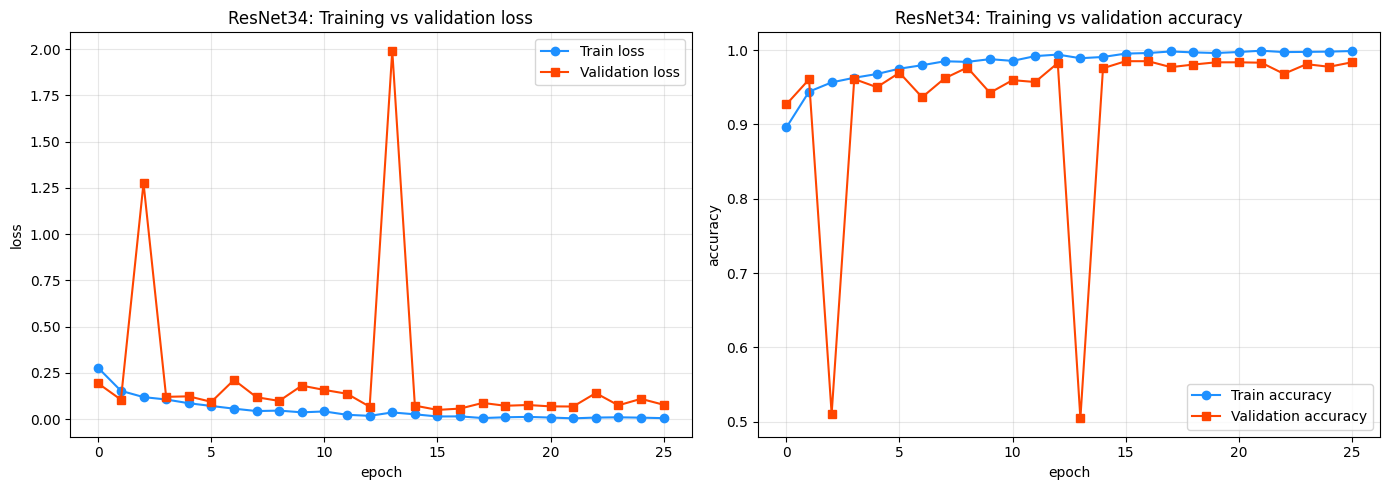

In [10]:
#Retrieve training stats for mobilenet
trainlosses = np.array([stat["trainloss"] for stat in stats_resnet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_resnet])
#Retrieve validation stats for mobilenet
vallosses = np.array([stat["valloss"] for stat in stats_resnet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_resnet])
#Retrieve epochs
epochs = np.array([stat["epoch"] for stat in stats_resnet])

#Plot training and validation curves for resnet with 2 subplots (loss and accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#Subplot 1 = loss (train and validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train loss', color='dodgerblue')
ax1.plot(epochs, vallosses, marker='s', label='Validation loss', color='orangered')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("ResNet34: Training vs validation loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

#Subplot 2 = accuracy (train and validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train accuracy', color='dodgerblue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation accuracy', color='orangered')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("ResNet34: Training vs validation accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/resnet_training_curves.png", dpi=150, bbox_inches='tight') #Save figure
plt.show()


### Evaluation of the models onto the test dataset

In [11]:
#Evaluate both models on the test set
testloss_mobilenet, testaccuracy_mobilenet = prediction_step(test_loader, model_mobilenet, device)
testloss_resnet, testaccuracy_resnet = prediction_step(test_loader, model_resnet, device)

#Display test results
print(f"MobileNet - test loss: {testloss_mobilenet:.4f}, test accuracy: {testaccuracy_mobilenet*100:.2f}%")
print(f"ResNet34  - test loss: {testloss_resnet:.4f}, test accuracy: {testaccuracy_resnet*100:.2f}%")

MobileNet - test loss: 0.1344, test accuracy: 95.55%
ResNet34  - test loss: 0.0147, test accuracy: 99.60%


### Visualize performance of both model using the best epoch

Results summary:
MobileNet: training accuracy =96.39%, validation accuracy =95.65%, test accuracy =95.55%, overfitting gap =0.74%
ResNet34: training accuracy =99.52%, validation accuracy =98.50%, test accuracy =99.60%, overfitting gap =1.02%


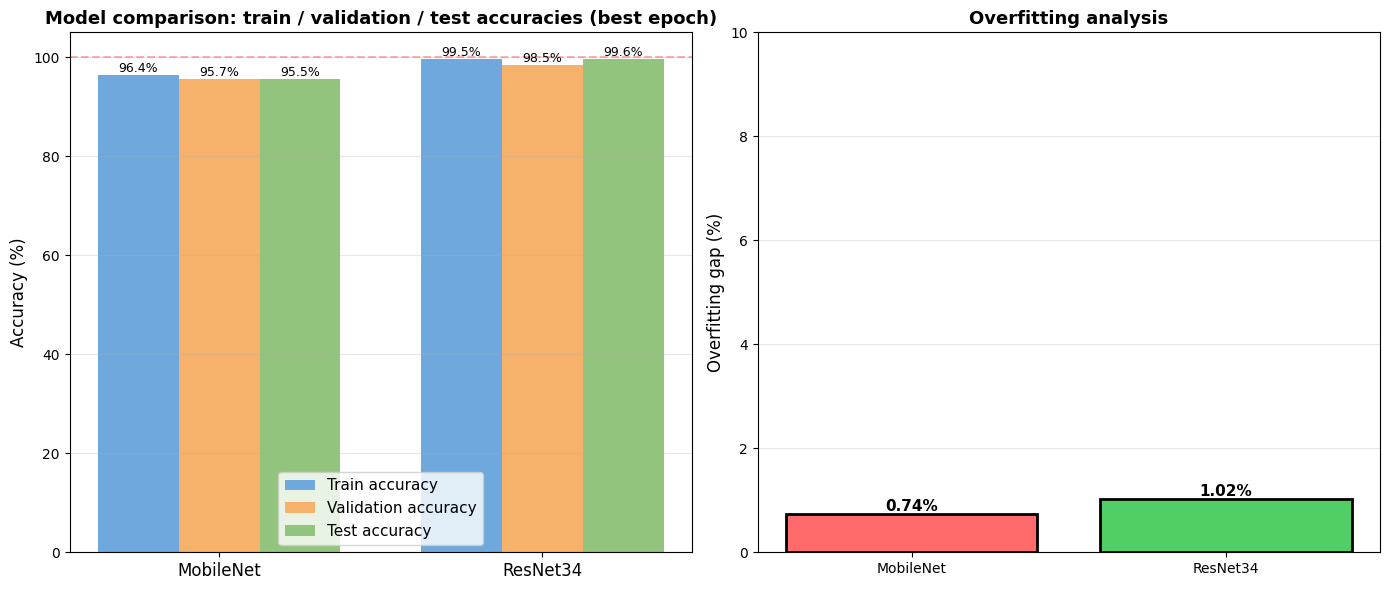

In [12]:
#Find the best epoch based on validation accuracy for both models
best_epoch_idx_mobilenet = np.argmax([stat["valaccuracy"] for stat in stats_mobilenet])
best_epoch_idx_resnet = np.argmax([stat["valaccuracy"] for stat in stats_resnet])

#Retrieve final train and validation accuracies at best epoch
final_trainacc_mobilenet = stats_mobilenet[best_epoch_idx_mobilenet]["trainaccuracy"]
final_valacc_mobilenet = stats_mobilenet[best_epoch_idx_mobilenet]["valaccuracy"]

final_trainacc_resnet = stats_resnet[best_epoch_idx_resnet]["trainaccuracy"]
final_valacc_resnet = stats_resnet[best_epoch_idx_resnet]["valaccuracy"]

#Derive overfitting gaps
overfitting_gap_mobilenet = final_trainacc_mobilenet - final_valacc_mobilenet
overfitting_gap_resnet = final_trainacc_resnet - final_valacc_resnet

#Create a summary table of results
print("Results summary:")
print(f"MobileNet: training accuracy ={final_trainacc_mobilenet*100:.2f}%, validation accuracy ={final_valacc_mobilenet*100:.2f}%, test accuracy ={testaccuracy_mobilenet*100:.2f}%, overfitting gap ={overfitting_gap_mobilenet*100:.2f}%")
print(f"ResNet34: training accuracy ={final_trainacc_resnet*100:.2f}%, validation accuracy ={final_valacc_resnet*100:.2f}%, test accuracy ={testaccuracy_resnet*100:.2f}%, overfitting gap ={overfitting_gap_resnet*100:.2f}%")

#Visualize comparison of both models with bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#Subplot 1 = Accuracies comparison
ax1 = axes[0]
models = ['MobileNet', 'ResNet34']
train_accs = [final_trainacc_mobilenet*100, final_trainacc_resnet*100]
val_accs = [final_valacc_mobilenet*100, final_valacc_resnet*100]
test_accs = [testaccuracy_mobilenet*100, testaccuracy_resnet*100]

x = np.arange(len(models))
width = 0.25

bars1 = ax1.bar(x - width, train_accs, width, label='Train accuracy', color='#6fa8dc')
bars2 = ax1.bar(x, val_accs, width, label='Validation accuracy', color='#f6b26b')
bars3 = ax1.bar(x + width, test_accs, width, label='Test accuracy', color='#93c47d')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model comparison: train / validation / test accuracies (best epoch)', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=12)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 105])
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=100, color='red', linestyle='--', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

#Subplot 2 = overfitting gap analysis
ax2 = axes[1]
gaps = [overfitting_gap_mobilenet*100, overfitting_gap_resnet*100]
colors_gap = ['#FF6B6B', '#51CF66']  #Red for high gap, green for low gap

bars = ax2.bar(models, gaps, color=colors_gap, edgecolor='black', linewidth=2)
ax2.set_ylabel('Overfitting gap (%)', fontsize=12)
ax2.set_title('Overfitting analysis', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 10])
ax2.grid(axis='y', alpha=0.3)

for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("outputs/model_comparison.png", dpi=150, bbox_inches='tight') #Save figure
plt.show()


### Visualisation of performance for both model wiht confusion matrix

/home/calvo/IPEO_production/scitas_venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


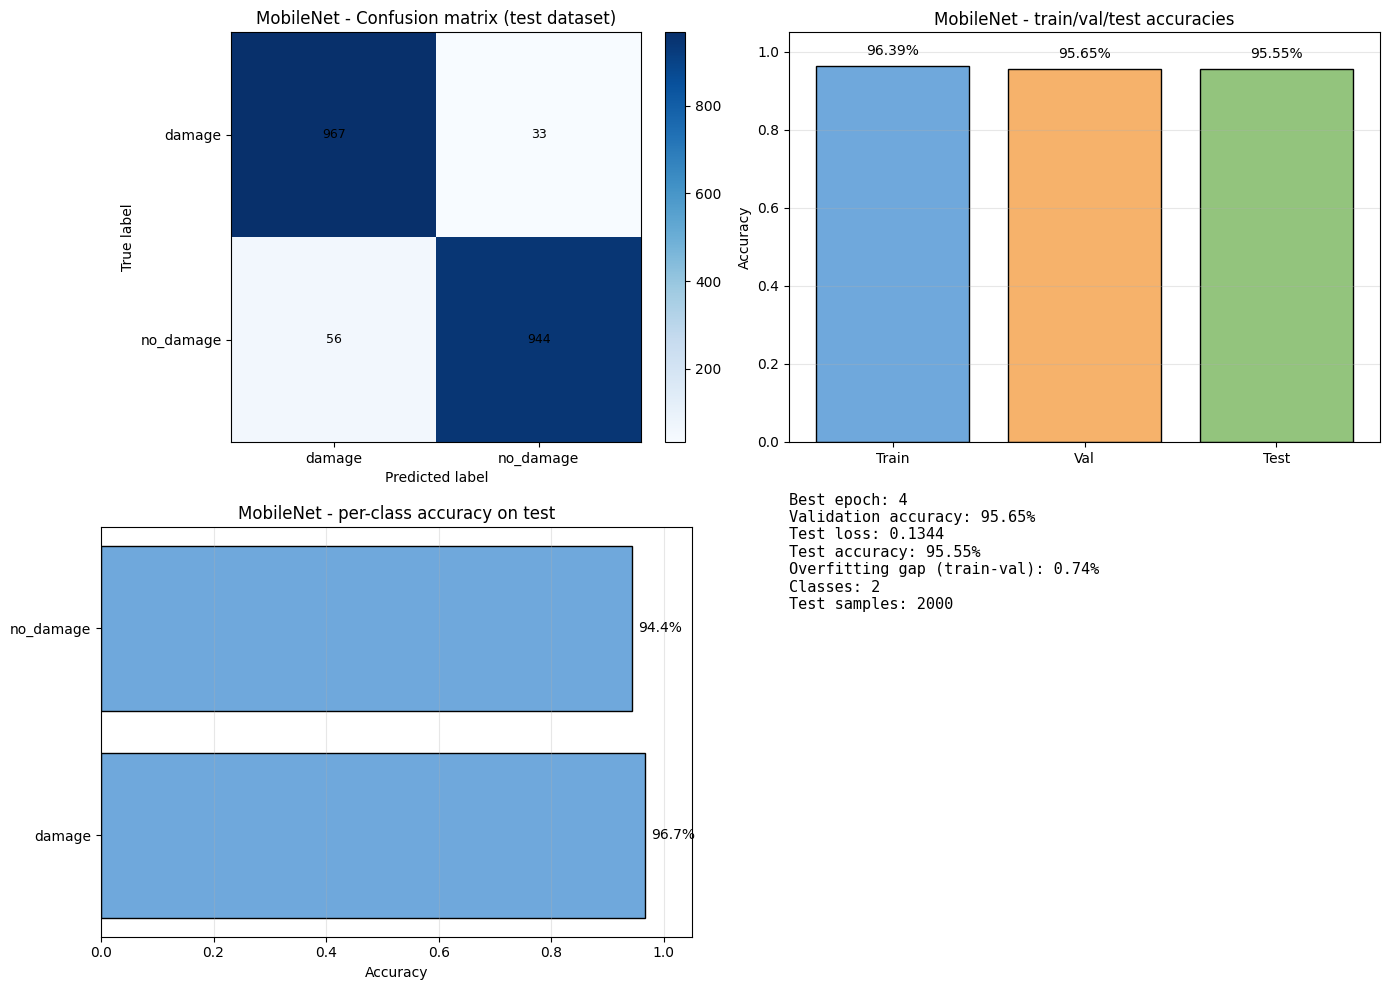

In [13]:
#Visualize detailed results for MobileNet
from sklearn.metrics import confusion_matrix

#Retrieve predictions and true labels on the test set
all_preds_mb, all_labels_mb = [], []
model_mobilenet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model_mobilenet(x)
        preds = y_hat.argmax(1)
        all_preds_mb.append(preds.cpu())
        all_labels_mb.append(y.cpu())

all_preds_mb = torch.cat(all_preds_mb).numpy()
all_labels_mb = torch.cat(all_labels_mb).numpy()

#Compute confusion matrix
class_names = test_ds.classes
cm_mb = confusion_matrix(all_labels_mb, all_preds_mb, labels=list(range(len(class_names))))
cm_norm_mb = cm_mb.astype(np.float64) / cm_mb.sum(axis=1, keepdims=True)

#Compute per-class accuracy
per_class_acc_mb = cm_mb.diagonal() / cm_mb.sum(axis=1)

#Retrieve key metrics
best_epoch_idx_mobilenet = np.argmax([stat["valaccuracy"] for stat in stats_mobilenet])
best_val_acc_mb = stats_mobilenet[best_epoch_idx_mobilenet]["valaccuracy"] * 100
train_acc_best_mb = stats_mobilenet[best_epoch_idx_mobilenet]["trainaccuracy"] * 100
val_acc_best_mb = best_val_acc_mb
test_acc_mb = testaccuracy_mobilenet * 100
test_loss_mb = testloss_mobilenet
overfit_gap_mb = train_acc_best_mb - val_acc_best_mb

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Confusion matrix (counts)
im0 = axes[0, 0].imshow(cm_mb, cmap="Blues")
axes[0, 0].set_title("MobileNet - Confusion matrix (test dataset)")
axes[0, 0].set_xlabel("Predicted label")
axes[0, 0].set_ylabel("True label")
axes[0, 0].set_xticks(range(len(class_names)))
axes[0, 0].set_yticks(range(len(class_names)))
axes[0, 0].set_xticklabels(class_names)
axes[0, 0].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0, 0].text(j, i, cm_mb[i, j], ha="center", va="center", color="black", fontsize=9)
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

#Barplot train / val / test accuracies
bars = axes[0, 1].bar(["Train", "Val", "Test"], [train_acc_best_mb/100, val_acc_best_mb/100, test_acc_mb/100], color=["#6fa8dc", "#f6b26b", "#93c47d"], edgecolor="black")
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_title("MobileNet - train/val/test accuracies")
for bar, acc in zip(bars, [train_acc_best_mb, val_acc_best_mb, test_acc_mb]):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{acc:.2f}%", ha="center", va="bottom", fontsize=10)
axes[0, 1].grid(axis="y", alpha=0.3)

#Per-class accuracies
bars_pc = axes[1, 0].barh(class_names, per_class_acc_mb, color="#6fa8dc", edgecolor="black")
axes[1, 0].set_xlim(0, 1.05)
axes[1, 0].set_xlabel("Accuracy")
axes[1, 0].set_title("MobileNet - per-class accuracy on test")
for bar, acc in zip(bars_pc, per_class_acc_mb):
    axes[1, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, f"{acc*100:.1f}%", va="center", fontsize=10)
axes[1, 0].grid(axis="x", alpha=0.3)

#Summary text
summary_text = (
    f"Best epoch: {best_epoch_idx_mobilenet+1}\n"
    f"Validation accuracy: {val_acc_best_mb:.2f}%\n"
    f"Test loss: {test_loss_mb:.4f}\n"
    f"Test accuracy: {test_acc_mb:.2f}%\n"
    f"Overfitting gap (train-val): {overfit_gap_mb:.2f}%\n"
    f"Classes: {len(class_names)}\n"
    f"Test samples: {len(all_labels_mb)}"
)
axes[1, 1].axis("off")
axes[1, 1].text(0, 0.8, summary_text, fontsize=11, family="monospace")

plt.tight_layout()
plt.savefig("outputs/mobilenet_test_report.png", dpi=150, bbox_inches="tight") #Save figure
plt.show()


/home/calvo/IPEO_production/scitas_venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


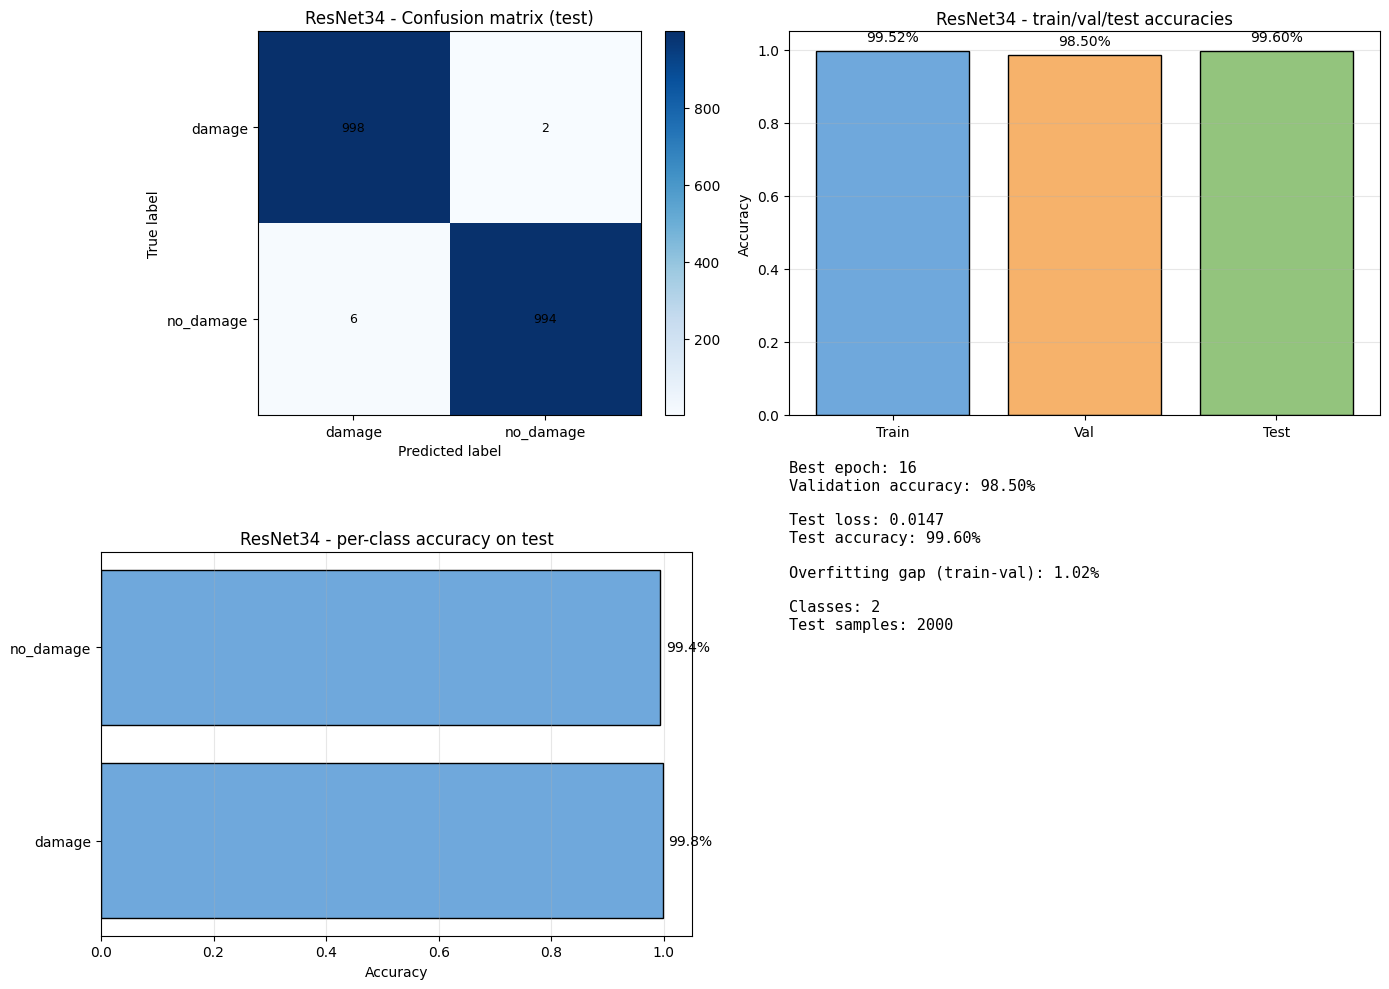

In [14]:
#Visualize detailed results for ResNet34

#Retrieve predictions and true labels on the test set
all_preds_resnet, all_labels_resnet = [], []
model_resnet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model_resnet(x)
        preds = y_hat.argmax(1)
        all_preds_resnet.append(preds.cpu())
        all_labels_resnet.append(y.cpu())

all_preds_resnet = torch.cat(all_preds_resnet).numpy()
all_labels_resnet = torch.cat(all_labels_resnet).numpy()

#Compute confusion matrix
class_names = test_ds.classes
cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet, labels=list(range(len(class_names))))
cm_norm_resnet = cm_resnet.astype(np.float64) / cm_resnet.sum(axis=1, keepdims=True)

#Compute per-class accuracy
per_class_acc_resnet = cm_resnet.diagonal() / cm_resnet.sum(axis=1)

#Retrieve key metrics
best_epoch_idx_resnet = np.argmax([stat["valaccuracy"] for stat in stats_resnet])
best_val_acc_resnet = stats_resnet[best_epoch_idx_resnet]["valaccuracy"] * 100
train_acc_best_resnet = stats_resnet[best_epoch_idx_resnet]["trainaccuracy"] * 100
val_acc_best_resnet = best_val_acc_resnet
test_acc_resnet = testaccuracy_resnet * 100
test_loss_resnet = testloss_resnet
overfit_gap_resnet = train_acc_best_resnet - val_acc_best_resnet

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Confusion matrix (counts)
im0 = axes[0, 0].imshow(cm_resnet, cmap="Blues")
axes[0, 0].set_title("ResNet34 - Confusion matrix (test)")
axes[0, 0].set_xlabel("Predicted label")
axes[0, 0].set_ylabel("True label")
axes[0, 0].set_xticks(range(len(class_names)))
axes[0, 0].set_yticks(range(len(class_names)))
axes[0, 0].set_xticklabels(class_names)
axes[0, 0].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0, 0].text(j, i, cm_resnet[i, j], ha="center", va="center", color="black", fontsize=9)
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

#Barplot train / val / test accuracies
bars = axes[0, 1].bar(["Train", "Val", "Test"], [train_acc_best_resnet/100, val_acc_best_resnet/100, test_acc_resnet/100], color=["#6fa8dc", "#f6b26b", "#93c47d"], edgecolor="black")
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_title("ResNet34 - train/val/test accuracies")
for bar, acc in zip(bars, [train_acc_best_resnet, val_acc_best_resnet, test_acc_resnet]):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{acc:.2f}%", ha="center", va="bottom", fontsize=10)
axes[0, 1].grid(axis="y", alpha=0.3)

# Per-class accuracies
bars_pc = axes[1, 0].barh(class_names, per_class_acc_resnet, color="#6fa8dc", edgecolor="black")
axes[1, 0].set_xlim(0, 1.05)
axes[1, 0].set_xlabel("Accuracy")
axes[1, 0].set_title("ResNet34 - per-class accuracy on test")
for bar, acc in zip(bars_pc, per_class_acc_resnet):
    axes[1, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, f"{acc*100:.1f}%", va="center", fontsize=10)
axes[1, 0].grid(axis="x", alpha=0.3)

#Summary text
summary_text = (
    f"Best epoch: {best_epoch_idx_resnet+1}\n"
    f"Validation accuracy: {val_acc_best_resnet:.2f}%\n\n"
    f"Test loss: {test_loss_resnet:.4f}\n"
    f"Test accuracy: {test_acc_resnet:.2f}%\n\n"
    f"Overfitting gap (train-val): {overfit_gap_resnet:.2f}%\n\n"
    f"Classes: {len(class_names)}\n"
    f"Test samples: {len(all_labels_resnet)}"
)
axes[1, 1].axis("off")
axes[1, 1].text(0, 0.8, summary_text, fontsize=11, family="monospace")

plt.tight_layout()
plt.savefig("outputs/resnet_test_report.png", dpi=150, bbox_inches="tight") #Save figure
plt.show()


### F1 score of each models

Compute F1 score, precision and recall

In [15]:
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

#Derive F1 score, precision and recall for mobilenet on the test set
f1_mobilenet = f1_score(all_labels_mb, all_preds_mb, average='weighted')
precision_mobilenet = precision_score(all_labels_mb, all_preds_mb, average='weighted')
recall_mobilenet = recall_score(all_labels_mb, all_preds_mb, average='weighted')

# Derive F1 score, precision and recall for resnet on the test set
f1_resnet = f1_score(all_labels_resnet, all_preds_resnet, average='weighted')
precision_resnet = precision_score(all_labels_resnet, all_preds_resnet, average='weighted')
recall_resnet = recall_score(all_labels_resnet, all_preds_resnet, average='weighted')

#Display results
print(f"MobileNet: precision = {precision_mobilenet:.2f}  recall = {recall_mobilenet:.2f}  f1 = {f1_mobilenet:.2f}")
print(f"ResNet34: precision = {precision_resnet:.2f}  recall = {recall_resnet:.2f}  f1 = {f1_resnet:.2f}")


#Classification report for both models
print("MobileNet classification report:")
print(classification_report(all_labels_mb, all_preds_mb, target_names=class_names))

print("ResNet34 classification report:")
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=class_names))

MobileNet: precision = 0.96  recall = 0.96  f1 = 0.96
ResNet34: precision = 1.00  recall = 1.00  f1 = 1.00
MobileNet classification report:
              precision    recall  f1-score   support

      damage       0.95      0.97      0.96      1000
   no_damage       0.97      0.94      0.95      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

ResNet34 classification report:
              precision    recall  f1-score   support

      damage       0.99      1.00      1.00      1000
   no_damage       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Visualisation of both models F1 score, recall and precision

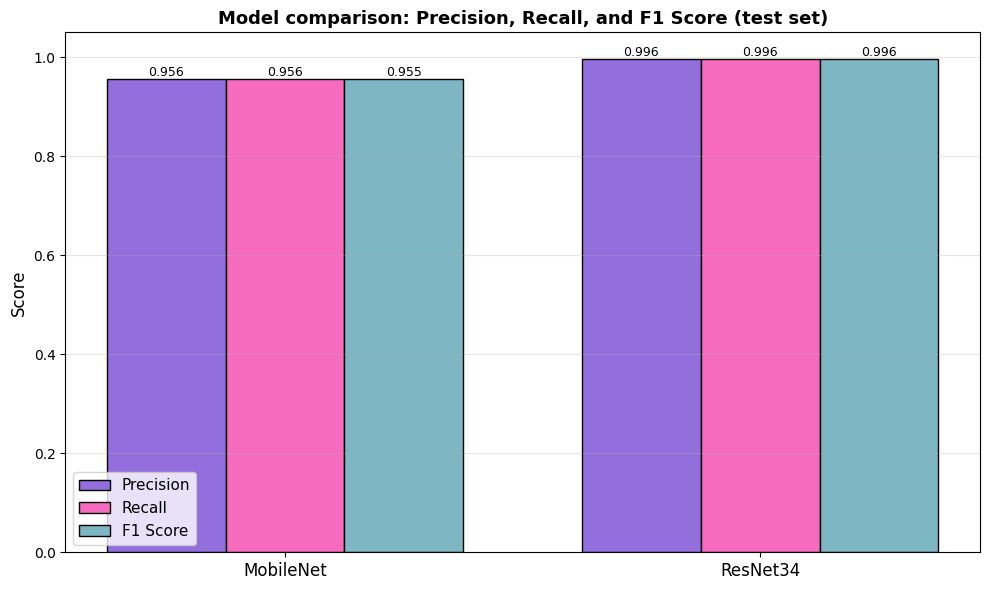

In [16]:
#Visualize F1 score, precision and recall comparison between both models
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = ['MobileNet', 'ResNet34']
f1_scores = [f1_mobilenet, f1_resnet]
precisions = [precision_mobilenet, precision_resnet]
recalls = [recall_mobilenet, recall_resnet]

x = np.arange(len(models))
width = 0.25

bars1 = ax.bar(x - width, precisions, width, label='Precision', color="#926fdc", edgecolor='black')
bars2 = ax.bar(x, recalls, width, label='Recall', color="#f66bbe", edgecolor='black')
bars3 = ax.bar(x + width, f1_scores, width, label='F1 Score', color="#7db7c4", edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model comparison: Precision, Recall, and F1 Score (test set)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("outputs/f1_score_comparison.png", dpi=150, bbox_inches='tight') #Save figure
plt.show()

## Second part - Training ResNet34 with data augmentation
ResNet34 performs better than MobileNet, so we keep only this model, and try to improve its performance with data augmentation

### Definition of the augmentation we want to do on our data

In [17]:
transforms_train = T.Compose([
    T.RandomResizedCrop(224, scale=(0.9, 1.0)),  #Random resized crop for data augmentation (size 224x224 for resnet)
    T.RandomHorizontalFlip(p=0.5), #horizontal flip with 50% probability
    T.RandomVerticalFlip(p=0.5), #vertical flip with 50% probability
    T.RandomRotation(degrees=10), #random rotation between -10 and +10 degrees
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), #random color jitter for brightness, contrast and saturation
    T.ToTensor(),
    normalize
])

#Reload training dataset with data augmentation transforms
train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transforms_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)

/home/calvo/IPEO_production/scitas_venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualize data augmented

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.063679..5.3000727].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.937062..3.6405487].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9687161..3.4213665].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.095333..4.8930197].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7975091..3.6718607].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0003705..3.9952183].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9054077..3.7031724].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9687161..4.955643].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.937062..4.3607197].


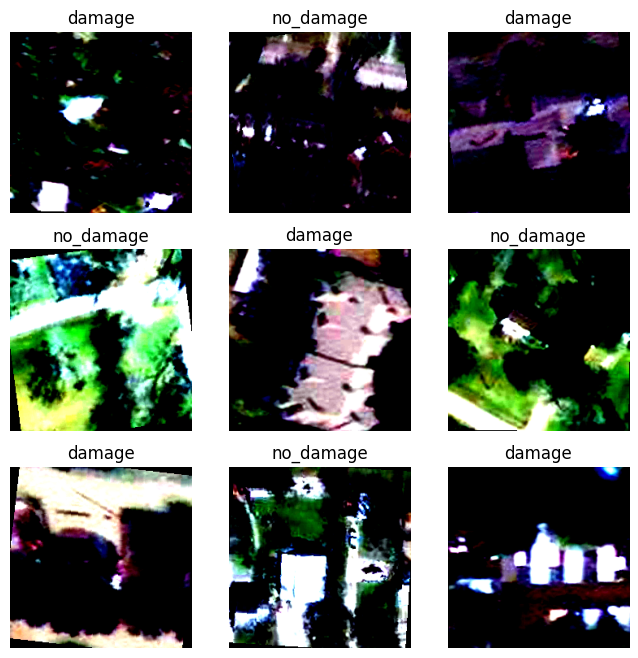

In [18]:
#Display a batch of augmented images
show_batch(train_loader)

### Training of ResNet34 with the augmented data

In [19]:
num_epochs = 50  #Long training with 50 epochs with early stopping

#create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

#early stopping configuration
patience = 10  #number of epochs without improvement before stopping
min_delta = 0.001  #minimum improvement considered (0.1%)

#check if models and stats exist to skip training (to avoid long re-training)
models_exist = (os.path.exists("models/resnet_final.pth") and 
                os.path.exists("models/stats_final.json"))

if models_exist:
    #open model (map_location for CPU/GPU compatibility)
    model_resnet.load_state_dict(torch.load("models/resnet_final.pth", map_location=device))
    
    #open stats
    with open("models/stats_final.json", "r") as f:
        saved_stats = json.load(f)
        stats_resnet = saved_stats["resnet"]
    train_models = False
else:
    train_models = True

#Training only if model does not already exist
if train_models:
    #Training of Resnet with early stopping
    stats_resnet = []
    best_val_acc_resnet = 0
    patience_counter_resnet = 0
    
    for epoch in range(num_epochs):
        print(f"Resnet - Epoch {epoch+1}/{num_epochs}") #Print epoch number to see progression
        #training and validation steps
        trainloss_resnet, trainaccuracy_resnet = train_epoch(train_loader, model_resnet, optimizer_resnet, device)
        valloss_resnet, valaccuracy_resnet = prediction_step(val_loader, model_resnet, device)

        #Visualize training/validation loss and accuracy for each epoch
        print(f"epoch {epoch}; trainloss {trainloss_resnet:.4f}, train accuracy {trainaccuracy_resnet*100:.2f}% | valloss {valloss_resnet:.4f}, val accuracy {valaccuracy_resnet*100:.2f}%")

        stats_resnet.append({
            "trainloss": float(trainloss_resnet),
            "trainaccuracy": float(trainaccuracy_resnet),
            "valloss": float(valloss_resnet),
            "valaccuracy": float(valaccuracy_resnet),
            "epoch": epoch
        })

        #Early stopping implementation
        if valaccuracy_resnet > best_val_acc_resnet + min_delta:
            best_val_acc_resnet = valaccuracy_resnet
            patience_counter_resnet = 0
            #Save best model
            torch.save(model_resnet.state_dict(), "models/resnet_final.pth")
        else:
            patience_counter_resnet += 1
            print(f"No improvement, patience: {patience_counter_resnet}/{patience}") #print patience status
            
            if patience_counter_resnet >= patience: #if patience exceeded, stop training => early stopping
                print(f"Best validation accuracy: {best_val_acc_resnet*100:.2f}%") 
                break

    #Save stats as JSON
    with open("models/stats_final.json", "w") as f:
        json.dump({"resnet": stats_resnet}, f)
else:
    print("Training skipped, models and stats already exist") #if models and stats exist, skip training


Resnet - Epoch 1/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0802, acc: 93.75%


  Batch 20/1188 - loss: 0.0602, acc: 93.75%


  Batch 30/1188 - loss: 0.0810, acc: 93.75%


  Batch 40/1188 - loss: 0.0399, acc: 93.75%


  Batch 50/1188 - loss: 0.0082, acc: 100.00%


  Batch 60/1188 - loss: 0.1006, acc: 93.75%


  Batch 70/1188 - loss: 0.0752, acc: 100.00%


  Batch 80/1188 - loss: 0.5185, acc: 87.50%


  Batch 90/1188 - loss: 0.0459, acc: 100.00%


  Batch 100/1188 - loss: 0.3079, acc: 87.50%


  Batch 110/1188 - loss: 0.2338, acc: 81.25%


  Batch 120/1188 - loss: 0.1736, acc: 93.75%


  Batch 130/1188 - loss: 0.1088, acc: 93.75%


  Batch 140/1188 - loss: 0.0191, acc: 100.00%


  Batch 150/1188 - loss: 0.0192, acc: 100.00%


  Batch 160/1188 - loss: 0.0583, acc: 93.75%


  Batch 170/1188 - loss: 0.1138, acc: 87.50%


  Batch 180/1188 - loss: 0.0174, acc: 100.00%


  Batch 190/1188 - loss: 0.6398, acc: 87.50%


  Batch 200/1188 - loss: 0.1807, acc: 87.50%


  Batch 210/1188 - loss: 0.0051, acc: 100.00%


  Batch 220/1188 - loss: 0.0481, acc: 100.00%


  Batch 230/1188 - loss: 0.5216, acc: 87.50%


  Batch 240/1188 - loss: 0.5831, acc: 87.50%


  Batch 250/1188 - loss: 0.0439, acc: 100.00%


  Batch 260/1188 - loss: 0.0440, acc: 93.75%


  Batch 270/1188 - loss: 0.2146, acc: 87.50%


  Batch 280/1188 - loss: 0.4184, acc: 87.50%


  Batch 290/1188 - loss: 0.0901, acc: 93.75%


  Batch 300/1188 - loss: 0.0516, acc: 100.00%


  Batch 310/1188 - loss: 0.0400, acc: 100.00%


  Batch 320/1188 - loss: 0.1145, acc: 93.75%


  Batch 330/1188 - loss: 0.0094, acc: 100.00%


  Batch 340/1188 - loss: 0.0245, acc: 100.00%


  Batch 350/1188 - loss: 0.0151, acc: 100.00%


  Batch 360/1188 - loss: 0.1280, acc: 93.75%


  Batch 370/1188 - loss: 0.6503, acc: 81.25%


  Batch 380/1188 - loss: 0.0266, acc: 100.00%


  Batch 390/1188 - loss: 0.1713, acc: 93.75%


  Batch 400/1188 - loss: 0.2429, acc: 93.75%


  Batch 410/1188 - loss: 0.5928, acc: 87.50%


  Batch 420/1188 - loss: 0.0344, acc: 100.00%


  Batch 430/1188 - loss: 0.2251, acc: 93.75%


  Batch 440/1188 - loss: 0.1529, acc: 93.75%


  Batch 450/1188 - loss: 0.0513, acc: 100.00%


  Batch 460/1188 - loss: 0.1133, acc: 93.75%


  Batch 470/1188 - loss: 0.1330, acc: 93.75%


  Batch 480/1188 - loss: 0.0141, acc: 100.00%


  Batch 490/1188 - loss: 0.0862, acc: 93.75%


  Batch 500/1188 - loss: 0.0671, acc: 93.75%


  Batch 510/1188 - loss: 0.2444, acc: 93.75%


  Batch 520/1188 - loss: 0.0479, acc: 100.00%


  Batch 530/1188 - loss: 0.0748, acc: 93.75%


  Batch 540/1188 - loss: 0.0030, acc: 100.00%


  Batch 550/1188 - loss: 0.6453, acc: 87.50%


  Batch 560/1188 - loss: 0.2126, acc: 93.75%


  Batch 570/1188 - loss: 1.0232, acc: 93.75%


  Batch 580/1188 - loss: 0.0171, acc: 100.00%


  Batch 590/1188 - loss: 0.0537, acc: 93.75%


  Batch 600/1188 - loss: 0.1688, acc: 93.75%


  Batch 610/1188 - loss: 0.0295, acc: 100.00%


  Batch 620/1188 - loss: 0.0789, acc: 93.75%


  Batch 630/1188 - loss: 0.0220, acc: 100.00%


  Batch 640/1188 - loss: 0.0225, acc: 100.00%


  Batch 650/1188 - loss: 0.0088, acc: 100.00%


  Batch 660/1188 - loss: 0.0052, acc: 100.00%


  Batch 670/1188 - loss: 0.0534, acc: 100.00%


  Batch 680/1188 - loss: 0.2707, acc: 87.50%


  Batch 690/1188 - loss: 0.4797, acc: 87.50%


  Batch 700/1188 - loss: 0.1147, acc: 93.75%


  Batch 710/1188 - loss: 0.0502, acc: 100.00%


  Batch 720/1188 - loss: 0.0845, acc: 100.00%


  Batch 730/1188 - loss: 0.0480, acc: 100.00%


  Batch 740/1188 - loss: 0.2280, acc: 87.50%


  Batch 750/1188 - loss: 0.0532, acc: 100.00%


  Batch 760/1188 - loss: 0.5491, acc: 87.50%


  Batch 770/1188 - loss: 0.0771, acc: 93.75%


  Batch 780/1188 - loss: 0.2536, acc: 87.50%


  Batch 790/1188 - loss: 0.0350, acc: 100.00%


  Batch 800/1188 - loss: 0.1312, acc: 93.75%


  Batch 810/1188 - loss: 0.0397, acc: 100.00%


  Batch 820/1188 - loss: 0.0275, acc: 100.00%


  Batch 830/1188 - loss: 0.0487, acc: 100.00%


  Batch 840/1188 - loss: 0.0715, acc: 100.00%


  Batch 850/1188 - loss: 0.0387, acc: 100.00%


  Batch 860/1188 - loss: 0.0168, acc: 100.00%


  Batch 870/1188 - loss: 0.1357, acc: 93.75%


  Batch 880/1188 - loss: 0.1121, acc: 93.75%


  Batch 890/1188 - loss: 0.1703, acc: 87.50%


  Batch 900/1188 - loss: 0.0411, acc: 100.00%


  Batch 910/1188 - loss: 0.0154, acc: 100.00%


  Batch 920/1188 - loss: 0.3897, acc: 87.50%


  Batch 930/1188 - loss: 0.0216, acc: 100.00%


  Batch 940/1188 - loss: 0.1305, acc: 93.75%


  Batch 950/1188 - loss: 0.0755, acc: 93.75%


  Batch 960/1188 - loss: 0.3864, acc: 81.25%


  Batch 970/1188 - loss: 0.0615, acc: 100.00%


  Batch 980/1188 - loss: 0.0310, acc: 100.00%


  Batch 990/1188 - loss: 0.1500, acc: 87.50%


  Batch 1000/1188 - loss: 0.0539, acc: 100.00%


  Batch 1010/1188 - loss: 0.0126, acc: 100.00%


  Batch 1020/1188 - loss: 0.0802, acc: 93.75%


  Batch 1030/1188 - loss: 0.2075, acc: 87.50%


  Batch 1040/1188 - loss: 0.0491, acc: 100.00%


  Batch 1050/1188 - loss: 0.0908, acc: 100.00%


  Batch 1060/1188 - loss: 0.5415, acc: 75.00%


  Batch 1070/1188 - loss: 0.0551, acc: 100.00%


  Batch 1080/1188 - loss: 0.0482, acc: 100.00%


  Batch 1090/1188 - loss: 0.1539, acc: 93.75%


  Batch 1100/1188 - loss: 0.1170, acc: 93.75%


  Batch 1110/1188 - loss: 0.1078, acc: 100.00%


  Batch 1120/1188 - loss: 0.4126, acc: 81.25%


  Batch 1130/1188 - loss: 0.0268, acc: 100.00%


  Batch 1140/1188 - loss: 0.0740, acc: 93.75%


  Batch 1150/1188 - loss: 0.0423, acc: 100.00%


  Batch 1160/1188 - loss: 0.1522, acc: 93.75%


  Batch 1170/1188 - loss: 0.0469, acc: 100.00%


  Batch 1180/1188 - loss: 0.0489, acc: 100.00%


  Batch 1188/1188 - loss: 0.0120, acc: 100.00%


epoch 0; trainloss 0.1490, train accuracy 94.66% | valloss 0.0707, val accuracy 97.30%
Resnet - Epoch 2/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0120, acc: 100.00%


  Batch 20/1188 - loss: 0.0158, acc: 100.00%


  Batch 30/1188 - loss: 0.0537, acc: 100.00%


  Batch 40/1188 - loss: 0.0586, acc: 100.00%


  Batch 50/1188 - loss: 0.1796, acc: 93.75%


  Batch 60/1188 - loss: 0.1521, acc: 93.75%


  Batch 70/1188 - loss: 0.0242, acc: 100.00%


  Batch 80/1188 - loss: 0.0371, acc: 100.00%


  Batch 90/1188 - loss: 0.2137, acc: 87.50%


  Batch 100/1188 - loss: 0.0679, acc: 93.75%


  Batch 110/1188 - loss: 0.6663, acc: 81.25%


  Batch 120/1188 - loss: 0.1141, acc: 93.75%


  Batch 130/1188 - loss: 0.0652, acc: 100.00%


  Batch 140/1188 - loss: 0.2127, acc: 87.50%


  Batch 150/1188 - loss: 0.0786, acc: 100.00%


  Batch 160/1188 - loss: 0.0204, acc: 100.00%


  Batch 170/1188 - loss: 0.0214, acc: 100.00%


  Batch 180/1188 - loss: 0.0553, acc: 100.00%


  Batch 190/1188 - loss: 0.0148, acc: 100.00%


  Batch 200/1188 - loss: 0.0390, acc: 100.00%


  Batch 210/1188 - loss: 0.1484, acc: 93.75%


  Batch 220/1188 - loss: 0.3738, acc: 81.25%


  Batch 230/1188 - loss: 0.0775, acc: 93.75%


  Batch 240/1188 - loss: 0.1857, acc: 87.50%


  Batch 250/1188 - loss: 0.0085, acc: 100.00%


  Batch 260/1188 - loss: 0.0394, acc: 100.00%


  Batch 270/1188 - loss: 0.0307, acc: 100.00%


  Batch 280/1188 - loss: 0.5331, acc: 93.75%


  Batch 290/1188 - loss: 0.1733, acc: 87.50%


  Batch 300/1188 - loss: 0.0065, acc: 100.00%


  Batch 310/1188 - loss: 0.1814, acc: 87.50%


  Batch 320/1188 - loss: 0.0433, acc: 100.00%


  Batch 330/1188 - loss: 0.1163, acc: 93.75%


  Batch 340/1188 - loss: 0.0987, acc: 93.75%


  Batch 350/1188 - loss: 0.0546, acc: 100.00%


  Batch 360/1188 - loss: 0.0212, acc: 100.00%


  Batch 370/1188 - loss: 0.0293, acc: 100.00%


  Batch 380/1188 - loss: 0.0100, acc: 100.00%


  Batch 390/1188 - loss: 0.0212, acc: 100.00%


  Batch 400/1188 - loss: 0.1449, acc: 93.75%


  Batch 410/1188 - loss: 0.0735, acc: 100.00%


  Batch 420/1188 - loss: 0.0420, acc: 100.00%


  Batch 430/1188 - loss: 0.0054, acc: 100.00%


  Batch 440/1188 - loss: 0.0395, acc: 100.00%


  Batch 450/1188 - loss: 0.0846, acc: 93.75%


  Batch 460/1188 - loss: 0.1620, acc: 93.75%


  Batch 470/1188 - loss: 0.2526, acc: 87.50%


  Batch 480/1188 - loss: 0.0040, acc: 100.00%


  Batch 490/1188 - loss: 0.0430, acc: 100.00%


  Batch 500/1188 - loss: 0.1810, acc: 87.50%


  Batch 510/1188 - loss: 0.0401, acc: 100.00%


  Batch 520/1188 - loss: 0.0015, acc: 100.00%


  Batch 530/1188 - loss: 0.0204, acc: 100.00%


  Batch 540/1188 - loss: 0.4511, acc: 87.50%


  Batch 550/1188 - loss: 0.2454, acc: 87.50%


  Batch 560/1188 - loss: 0.0265, acc: 100.00%


  Batch 570/1188 - loss: 0.0073, acc: 100.00%


  Batch 580/1188 - loss: 0.0056, acc: 100.00%


  Batch 590/1188 - loss: 0.3355, acc: 87.50%


  Batch 600/1188 - loss: 0.0080, acc: 100.00%


  Batch 610/1188 - loss: 0.0684, acc: 93.75%


  Batch 620/1188 - loss: 0.1740, acc: 93.75%


  Batch 630/1188 - loss: 0.0267, acc: 100.00%


  Batch 640/1188 - loss: 0.2586, acc: 87.50%


  Batch 650/1188 - loss: 0.0610, acc: 100.00%


  Batch 660/1188 - loss: 0.0114, acc: 100.00%


  Batch 670/1188 - loss: 0.0421, acc: 100.00%


  Batch 680/1188 - loss: 0.0106, acc: 100.00%


  Batch 690/1188 - loss: 0.0458, acc: 100.00%


  Batch 700/1188 - loss: 0.0139, acc: 100.00%


  Batch 710/1188 - loss: 0.0212, acc: 100.00%


  Batch 720/1188 - loss: 0.0165, acc: 100.00%


  Batch 730/1188 - loss: 0.0883, acc: 100.00%


  Batch 740/1188 - loss: 0.1170, acc: 100.00%


  Batch 750/1188 - loss: 0.0091, acc: 100.00%


  Batch 760/1188 - loss: 0.0466, acc: 100.00%


  Batch 770/1188 - loss: 0.0605, acc: 100.00%


  Batch 780/1188 - loss: 0.0901, acc: 93.75%


  Batch 790/1188 - loss: 0.1057, acc: 93.75%


  Batch 800/1188 - loss: 0.1820, acc: 93.75%


  Batch 810/1188 - loss: 0.0397, acc: 100.00%


  Batch 820/1188 - loss: 0.1052, acc: 100.00%


  Batch 830/1188 - loss: 0.0830, acc: 93.75%


  Batch 840/1188 - loss: 0.0531, acc: 100.00%


  Batch 850/1188 - loss: 0.1781, acc: 93.75%


  Batch 860/1188 - loss: 0.0248, acc: 100.00%


  Batch 870/1188 - loss: 0.1925, acc: 93.75%


  Batch 880/1188 - loss: 0.1069, acc: 93.75%


  Batch 890/1188 - loss: 0.0436, acc: 100.00%


  Batch 900/1188 - loss: 0.0300, acc: 100.00%


  Batch 910/1188 - loss: 0.1045, acc: 87.50%


  Batch 920/1188 - loss: 0.0165, acc: 100.00%


  Batch 930/1188 - loss: 0.0103, acc: 100.00%


  Batch 940/1188 - loss: 0.0134, acc: 100.00%


  Batch 950/1188 - loss: 0.0014, acc: 100.00%


  Batch 960/1188 - loss: 0.1306, acc: 93.75%


  Batch 970/1188 - loss: 0.0413, acc: 100.00%


  Batch 980/1188 - loss: 0.0196, acc: 100.00%


  Batch 990/1188 - loss: 0.0424, acc: 100.00%


  Batch 1000/1188 - loss: 0.1455, acc: 93.75%


  Batch 1010/1188 - loss: 0.0794, acc: 93.75%


  Batch 1020/1188 - loss: 0.0918, acc: 93.75%


  Batch 1030/1188 - loss: 0.1608, acc: 93.75%


  Batch 1040/1188 - loss: 0.5336, acc: 75.00%


  Batch 1050/1188 - loss: 0.0253, acc: 100.00%


  Batch 1060/1188 - loss: 0.0699, acc: 100.00%


  Batch 1070/1188 - loss: 0.0591, acc: 100.00%


  Batch 1080/1188 - loss: 0.0086, acc: 100.00%


  Batch 1090/1188 - loss: 0.0176, acc: 100.00%


  Batch 1100/1188 - loss: 0.0768, acc: 93.75%


  Batch 1110/1188 - loss: 0.3831, acc: 93.75%


  Batch 1120/1188 - loss: 0.0362, acc: 100.00%


  Batch 1130/1188 - loss: 0.0576, acc: 93.75%


  Batch 1140/1188 - loss: 0.1608, acc: 93.75%


  Batch 1150/1188 - loss: 0.0286, acc: 100.00%


  Batch 1160/1188 - loss: 0.0646, acc: 93.75%


  Batch 1170/1188 - loss: 0.1985, acc: 93.75%


  Batch 1180/1188 - loss: 0.2507, acc: 87.50%


  Batch 1188/1188 - loss: 0.1186, acc: 87.50%


epoch 1; trainloss 0.0963, train accuracy 96.32% | valloss 0.0688, val accuracy 97.90%
Resnet - Epoch 3/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0134, acc: 100.00%


  Batch 20/1188 - loss: 0.1059, acc: 93.75%


  Batch 30/1188 - loss: 0.0024, acc: 100.00%


  Batch 40/1188 - loss: 0.0880, acc: 100.00%


  Batch 50/1188 - loss: 0.0883, acc: 93.75%


  Batch 60/1188 - loss: 0.0116, acc: 100.00%


  Batch 70/1188 - loss: 0.0163, acc: 100.00%


  Batch 80/1188 - loss: 0.0143, acc: 100.00%


  Batch 90/1188 - loss: 0.0088, acc: 100.00%


  Batch 100/1188 - loss: 0.0460, acc: 100.00%


  Batch 110/1188 - loss: 0.0515, acc: 93.75%


  Batch 120/1188 - loss: 0.0331, acc: 100.00%


  Batch 130/1188 - loss: 0.0216, acc: 100.00%


  Batch 140/1188 - loss: 0.0443, acc: 100.00%


  Batch 150/1188 - loss: 0.6945, acc: 81.25%


  Batch 160/1188 - loss: 0.0151, acc: 100.00%


  Batch 170/1188 - loss: 0.0281, acc: 100.00%


  Batch 180/1188 - loss: 0.2926, acc: 87.50%


  Batch 190/1188 - loss: 0.0116, acc: 100.00%


  Batch 200/1188 - loss: 0.0080, acc: 100.00%


  Batch 210/1188 - loss: 0.0517, acc: 100.00%


  Batch 220/1188 - loss: 0.1472, acc: 93.75%


  Batch 230/1188 - loss: 0.0110, acc: 100.00%


  Batch 240/1188 - loss: 0.1082, acc: 93.75%


  Batch 250/1188 - loss: 0.0739, acc: 93.75%


  Batch 260/1188 - loss: 0.2425, acc: 93.75%


  Batch 270/1188 - loss: 0.0524, acc: 93.75%


  Batch 280/1188 - loss: 1.0512, acc: 81.25%


  Batch 290/1188 - loss: 0.1047, acc: 93.75%


  Batch 300/1188 - loss: 0.0317, acc: 100.00%


  Batch 310/1188 - loss: 0.0348, acc: 100.00%


  Batch 320/1188 - loss: 0.0149, acc: 100.00%


  Batch 330/1188 - loss: 0.0953, acc: 93.75%


  Batch 340/1188 - loss: 0.0161, acc: 100.00%


  Batch 350/1188 - loss: 0.0491, acc: 100.00%


  Batch 360/1188 - loss: 0.0304, acc: 100.00%


  Batch 370/1188 - loss: 0.0108, acc: 100.00%


  Batch 380/1188 - loss: 0.1416, acc: 93.75%


  Batch 390/1188 - loss: 0.1086, acc: 93.75%


  Batch 400/1188 - loss: 0.0115, acc: 100.00%


  Batch 410/1188 - loss: 0.0583, acc: 100.00%


  Batch 420/1188 - loss: 0.0119, acc: 100.00%


  Batch 430/1188 - loss: 0.1481, acc: 93.75%


  Batch 440/1188 - loss: 0.0397, acc: 100.00%


  Batch 450/1188 - loss: 0.0237, acc: 100.00%


  Batch 460/1188 - loss: 0.0150, acc: 100.00%


  Batch 470/1188 - loss: 0.0024, acc: 100.00%


  Batch 480/1188 - loss: 0.0199, acc: 100.00%


  Batch 490/1188 - loss: 0.0143, acc: 100.00%


  Batch 500/1188 - loss: 0.3027, acc: 93.75%


  Batch 510/1188 - loss: 0.0060, acc: 100.00%


  Batch 520/1188 - loss: 0.0118, acc: 100.00%


  Batch 530/1188 - loss: 0.0282, acc: 100.00%


  Batch 540/1188 - loss: 0.0056, acc: 100.00%


  Batch 550/1188 - loss: 0.0645, acc: 93.75%


  Batch 560/1188 - loss: 0.0423, acc: 93.75%


  Batch 570/1188 - loss: 0.0095, acc: 100.00%


  Batch 580/1188 - loss: 0.0266, acc: 100.00%


  Batch 590/1188 - loss: 0.0145, acc: 100.00%


  Batch 600/1188 - loss: 0.2236, acc: 93.75%


  Batch 610/1188 - loss: 0.0364, acc: 93.75%


  Batch 620/1188 - loss: 0.0299, acc: 100.00%


  Batch 630/1188 - loss: 0.0922, acc: 93.75%


  Batch 640/1188 - loss: 0.0728, acc: 100.00%


  Batch 650/1188 - loss: 0.0197, acc: 100.00%


  Batch 660/1188 - loss: 0.0657, acc: 100.00%


  Batch 670/1188 - loss: 0.0220, acc: 100.00%


  Batch 680/1188 - loss: 0.0319, acc: 100.00%


  Batch 690/1188 - loss: 0.0134, acc: 100.00%


  Batch 700/1188 - loss: 0.1940, acc: 93.75%


  Batch 710/1188 - loss: 0.0561, acc: 93.75%


  Batch 720/1188 - loss: 0.0049, acc: 100.00%


  Batch 730/1188 - loss: 0.0034, acc: 100.00%


  Batch 740/1188 - loss: 0.0634, acc: 93.75%


  Batch 750/1188 - loss: 0.0214, acc: 100.00%


  Batch 760/1188 - loss: 0.0428, acc: 100.00%


  Batch 770/1188 - loss: 0.1282, acc: 93.75%


  Batch 780/1188 - loss: 0.1107, acc: 93.75%


  Batch 790/1188 - loss: 0.0848, acc: 93.75%


  Batch 800/1188 - loss: 0.0231, acc: 100.00%


  Batch 810/1188 - loss: 0.0447, acc: 100.00%


  Batch 820/1188 - loss: 0.0803, acc: 100.00%


  Batch 830/1188 - loss: 0.0269, acc: 100.00%


  Batch 840/1188 - loss: 0.1251, acc: 87.50%


  Batch 850/1188 - loss: 0.0325, acc: 100.00%


  Batch 860/1188 - loss: 0.1010, acc: 93.75%


  Batch 870/1188 - loss: 0.0077, acc: 100.00%


  Batch 880/1188 - loss: 0.3089, acc: 93.75%


  Batch 890/1188 - loss: 0.0080, acc: 100.00%


  Batch 900/1188 - loss: 0.0249, acc: 100.00%


  Batch 910/1188 - loss: 0.0060, acc: 100.00%


  Batch 920/1188 - loss: 0.1159, acc: 93.75%


  Batch 930/1188 - loss: 0.0234, acc: 100.00%


  Batch 940/1188 - loss: 0.0372, acc: 100.00%


  Batch 950/1188 - loss: 0.3183, acc: 93.75%


  Batch 960/1188 - loss: 0.0123, acc: 100.00%


  Batch 970/1188 - loss: 0.0271, acc: 100.00%


  Batch 980/1188 - loss: 0.0350, acc: 100.00%


  Batch 990/1188 - loss: 0.0356, acc: 100.00%


  Batch 1000/1188 - loss: 0.0131, acc: 100.00%


  Batch 1010/1188 - loss: 0.0307, acc: 100.00%


  Batch 1020/1188 - loss: 0.0475, acc: 100.00%


  Batch 1030/1188 - loss: 0.0591, acc: 93.75%


  Batch 1040/1188 - loss: 0.2497, acc: 93.75%


  Batch 1050/1188 - loss: 0.1066, acc: 93.75%


  Batch 1060/1188 - loss: 0.3457, acc: 93.75%


  Batch 1070/1188 - loss: 0.2478, acc: 93.75%


  Batch 1080/1188 - loss: 0.0132, acc: 100.00%


  Batch 1090/1188 - loss: 0.1824, acc: 93.75%


  Batch 1100/1188 - loss: 0.0127, acc: 100.00%


  Batch 1110/1188 - loss: 0.0674, acc: 100.00%


  Batch 1120/1188 - loss: 0.0354, acc: 100.00%


  Batch 1130/1188 - loss: 0.0038, acc: 100.00%


  Batch 1140/1188 - loss: 0.0173, acc: 100.00%


  Batch 1150/1188 - loss: 0.0275, acc: 100.00%


  Batch 1160/1188 - loss: 0.0804, acc: 100.00%


  Batch 1170/1188 - loss: 0.0328, acc: 100.00%


  Batch 1180/1188 - loss: 0.4027, acc: 93.75%


  Batch 1188/1188 - loss: 0.0019, acc: 100.00%


epoch 2; trainloss 0.0907, train accuracy 96.51% | valloss 0.0638, val accuracy 97.30%
No improvement, patience: 1/10
Resnet - Epoch 4/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0023, acc: 100.00%


  Batch 20/1188 - loss: 0.0754, acc: 100.00%


  Batch 30/1188 - loss: 0.0084, acc: 100.00%


  Batch 40/1188 - loss: 0.0383, acc: 100.00%


  Batch 50/1188 - loss: 0.0497, acc: 100.00%


  Batch 60/1188 - loss: 0.0060, acc: 100.00%


  Batch 70/1188 - loss: 0.0026, acc: 100.00%


  Batch 80/1188 - loss: 0.0286, acc: 100.00%


  Batch 90/1188 - loss: 0.0007, acc: 100.00%


  Batch 100/1188 - loss: 0.1296, acc: 93.75%


  Batch 110/1188 - loss: 0.0029, acc: 100.00%


  Batch 120/1188 - loss: 0.2891, acc: 93.75%


  Batch 130/1188 - loss: 0.1266, acc: 93.75%


  Batch 140/1188 - loss: 0.0137, acc: 100.00%


  Batch 150/1188 - loss: 0.0665, acc: 93.75%


  Batch 160/1188 - loss: 1.1686, acc: 87.50%


  Batch 170/1188 - loss: 0.1067, acc: 93.75%


  Batch 180/1188 - loss: 0.0387, acc: 100.00%


  Batch 190/1188 - loss: 0.0431, acc: 100.00%


  Batch 200/1188 - loss: 0.0056, acc: 100.00%


  Batch 210/1188 - loss: 0.1280, acc: 93.75%


  Batch 220/1188 - loss: 0.2804, acc: 93.75%


  Batch 230/1188 - loss: 0.1018, acc: 100.00%


  Batch 240/1188 - loss: 0.0311, acc: 100.00%


  Batch 250/1188 - loss: 0.0068, acc: 100.00%


  Batch 260/1188 - loss: 0.1060, acc: 93.75%


  Batch 270/1188 - loss: 0.0203, acc: 100.00%


  Batch 280/1188 - loss: 0.0343, acc: 100.00%


  Batch 290/1188 - loss: 0.0394, acc: 100.00%


  Batch 300/1188 - loss: 0.0097, acc: 100.00%


  Batch 310/1188 - loss: 0.0166, acc: 100.00%


  Batch 320/1188 - loss: 0.1005, acc: 93.75%


  Batch 330/1188 - loss: 0.0779, acc: 93.75%


  Batch 340/1188 - loss: 0.0556, acc: 100.00%


  Batch 350/1188 - loss: 0.0081, acc: 100.00%


  Batch 360/1188 - loss: 0.0326, acc: 100.00%


  Batch 370/1188 - loss: 0.0337, acc: 93.75%


  Batch 380/1188 - loss: 0.0109, acc: 100.00%


  Batch 390/1188 - loss: 0.0055, acc: 100.00%


  Batch 400/1188 - loss: 0.0081, acc: 100.00%


  Batch 410/1188 - loss: 0.2472, acc: 87.50%


  Batch 420/1188 - loss: 0.0042, acc: 100.00%


  Batch 430/1188 - loss: 0.0226, acc: 100.00%


  Batch 440/1188 - loss: 0.0994, acc: 93.75%


  Batch 450/1188 - loss: 0.1456, acc: 87.50%


  Batch 460/1188 - loss: 0.0610, acc: 100.00%


  Batch 470/1188 - loss: 0.0099, acc: 100.00%


  Batch 480/1188 - loss: 0.0073, acc: 100.00%


  Batch 490/1188 - loss: 0.0203, acc: 100.00%


  Batch 500/1188 - loss: 0.0494, acc: 100.00%


  Batch 510/1188 - loss: 0.0908, acc: 93.75%


  Batch 520/1188 - loss: 0.0191, acc: 100.00%


  Batch 530/1188 - loss: 0.0031, acc: 100.00%


  Batch 540/1188 - loss: 1.2833, acc: 56.25%


  Batch 550/1188 - loss: 0.3390, acc: 87.50%


  Batch 560/1188 - loss: 0.0134, acc: 100.00%


  Batch 570/1188 - loss: 0.0263, acc: 100.00%


  Batch 580/1188 - loss: 0.0869, acc: 93.75%


  Batch 590/1188 - loss: 0.1233, acc: 87.50%


  Batch 600/1188 - loss: 0.0216, acc: 100.00%


  Batch 610/1188 - loss: 0.0585, acc: 100.00%


  Batch 620/1188 - loss: 0.0486, acc: 100.00%


  Batch 630/1188 - loss: 0.0486, acc: 100.00%


  Batch 640/1188 - loss: 0.0153, acc: 100.00%


  Batch 650/1188 - loss: 0.0528, acc: 93.75%


  Batch 660/1188 - loss: 0.0319, acc: 100.00%


  Batch 670/1188 - loss: 0.0836, acc: 93.75%


  Batch 680/1188 - loss: 0.0079, acc: 100.00%


  Batch 690/1188 - loss: 0.1044, acc: 93.75%


  Batch 700/1188 - loss: 0.1234, acc: 93.75%


  Batch 710/1188 - loss: 0.0531, acc: 100.00%


  Batch 720/1188 - loss: 0.3966, acc: 81.25%


  Batch 730/1188 - loss: 0.2063, acc: 93.75%


  Batch 740/1188 - loss: 0.0454, acc: 93.75%


  Batch 750/1188 - loss: 0.0027, acc: 100.00%


  Batch 760/1188 - loss: 0.0214, acc: 100.00%


  Batch 770/1188 - loss: 0.2413, acc: 93.75%


  Batch 780/1188 - loss: 0.1659, acc: 93.75%


  Batch 790/1188 - loss: 0.0081, acc: 100.00%


  Batch 800/1188 - loss: 0.0105, acc: 100.00%


  Batch 810/1188 - loss: 0.0625, acc: 93.75%


  Batch 820/1188 - loss: 0.6325, acc: 93.75%


  Batch 830/1188 - loss: 0.0901, acc: 100.00%


  Batch 840/1188 - loss: 0.0345, acc: 100.00%


  Batch 850/1188 - loss: 0.0160, acc: 100.00%


  Batch 860/1188 - loss: 0.1641, acc: 87.50%


  Batch 870/1188 - loss: 0.0244, acc: 100.00%


  Batch 880/1188 - loss: 0.0062, acc: 100.00%


  Batch 890/1188 - loss: 0.1672, acc: 93.75%


  Batch 900/1188 - loss: 0.0301, acc: 100.00%


  Batch 910/1188 - loss: 0.0408, acc: 100.00%


  Batch 920/1188 - loss: 0.0928, acc: 93.75%


  Batch 930/1188 - loss: 0.3703, acc: 93.75%


  Batch 940/1188 - loss: 0.2157, acc: 87.50%


  Batch 950/1188 - loss: 0.0544, acc: 100.00%


  Batch 960/1188 - loss: 0.0084, acc: 100.00%


  Batch 970/1188 - loss: 0.0821, acc: 100.00%


  Batch 980/1188 - loss: 0.0968, acc: 93.75%


  Batch 990/1188 - loss: 0.0847, acc: 87.50%


  Batch 1000/1188 - loss: 0.0788, acc: 93.75%


  Batch 1010/1188 - loss: 0.0577, acc: 100.00%


  Batch 1020/1188 - loss: 0.1902, acc: 93.75%


  Batch 1030/1188 - loss: 0.0584, acc: 93.75%


  Batch 1040/1188 - loss: 0.0170, acc: 100.00%


  Batch 1050/1188 - loss: 0.0206, acc: 100.00%


  Batch 1060/1188 - loss: 0.1321, acc: 93.75%


  Batch 1070/1188 - loss: 0.0217, acc: 100.00%


  Batch 1080/1188 - loss: 0.0537, acc: 100.00%


  Batch 1090/1188 - loss: 0.1674, acc: 93.75%


  Batch 1100/1188 - loss: 0.1160, acc: 87.50%


  Batch 1110/1188 - loss: 0.0085, acc: 100.00%


  Batch 1120/1188 - loss: 0.0910, acc: 93.75%


  Batch 1130/1188 - loss: 0.0135, acc: 100.00%


  Batch 1140/1188 - loss: 0.0224, acc: 100.00%


  Batch 1150/1188 - loss: 0.0958, acc: 93.75%


  Batch 1160/1188 - loss: 0.1161, acc: 93.75%


  Batch 1170/1188 - loss: 0.1360, acc: 100.00%


  Batch 1180/1188 - loss: 0.0103, acc: 100.00%


  Batch 1188/1188 - loss: 0.2104, acc: 87.50%


epoch 3; trainloss 0.0795, train accuracy 97.10% | valloss 0.2710, val accuracy 90.50%
No improvement, patience: 2/10
Resnet - Epoch 5/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0302, acc: 100.00%


  Batch 20/1188 - loss: 0.0328, acc: 100.00%


  Batch 30/1188 - loss: 0.0019, acc: 100.00%


  Batch 40/1188 - loss: 0.0104, acc: 100.00%


  Batch 50/1188 - loss: 0.0075, acc: 100.00%


  Batch 60/1188 - loss: 0.0278, acc: 100.00%


  Batch 70/1188 - loss: 0.0492, acc: 100.00%


  Batch 80/1188 - loss: 0.0335, acc: 100.00%


  Batch 90/1188 - loss: 0.1116, acc: 93.75%


  Batch 100/1188 - loss: 0.1418, acc: 93.75%


  Batch 110/1188 - loss: 0.0364, acc: 100.00%


  Batch 120/1188 - loss: 0.7879, acc: 68.75%


  Batch 130/1188 - loss: 0.0091, acc: 100.00%


  Batch 140/1188 - loss: 0.0152, acc: 100.00%


  Batch 150/1188 - loss: 0.0080, acc: 100.00%


  Batch 160/1188 - loss: 0.0157, acc: 100.00%


  Batch 170/1188 - loss: 0.1952, acc: 93.75%


  Batch 180/1188 - loss: 0.4278, acc: 81.25%


  Batch 190/1188 - loss: 0.0831, acc: 100.00%


  Batch 200/1188 - loss: 0.0253, acc: 100.00%


  Batch 210/1188 - loss: 0.0382, acc: 100.00%


  Batch 220/1188 - loss: 0.0096, acc: 100.00%


  Batch 230/1188 - loss: 0.3673, acc: 93.75%


  Batch 240/1188 - loss: 0.2366, acc: 87.50%


  Batch 250/1188 - loss: 0.0832, acc: 93.75%


  Batch 260/1188 - loss: 0.0323, acc: 100.00%


  Batch 270/1188 - loss: 0.0182, acc: 100.00%


  Batch 280/1188 - loss: 0.0917, acc: 93.75%


  Batch 290/1188 - loss: 0.0325, acc: 100.00%


  Batch 300/1188 - loss: 0.0337, acc: 100.00%


  Batch 310/1188 - loss: 0.0281, acc: 100.00%


  Batch 320/1188 - loss: 0.1358, acc: 93.75%


  Batch 330/1188 - loss: 0.0075, acc: 100.00%


  Batch 340/1188 - loss: 0.0062, acc: 100.00%


  Batch 350/1188 - loss: 0.0915, acc: 93.75%


  Batch 360/1188 - loss: 0.0263, acc: 100.00%


  Batch 370/1188 - loss: 0.0969, acc: 93.75%


  Batch 380/1188 - loss: 0.1567, acc: 93.75%


  Batch 390/1188 - loss: 0.3139, acc: 93.75%


  Batch 400/1188 - loss: 0.0142, acc: 100.00%


  Batch 410/1188 - loss: 0.0394, acc: 93.75%


  Batch 420/1188 - loss: 0.0064, acc: 100.00%


  Batch 430/1188 - loss: 0.0167, acc: 100.00%


  Batch 440/1188 - loss: 0.0054, acc: 100.00%


  Batch 450/1188 - loss: 0.0193, acc: 100.00%


  Batch 460/1188 - loss: 0.0189, acc: 100.00%


  Batch 470/1188 - loss: 0.1345, acc: 93.75%


  Batch 480/1188 - loss: 0.0212, acc: 100.00%


  Batch 490/1188 - loss: 0.1868, acc: 81.25%


  Batch 500/1188 - loss: 0.0051, acc: 100.00%


  Batch 510/1188 - loss: 0.0307, acc: 100.00%


  Batch 520/1188 - loss: 0.0127, acc: 100.00%


  Batch 530/1188 - loss: 0.0111, acc: 100.00%


  Batch 540/1188 - loss: 0.0141, acc: 100.00%


  Batch 550/1188 - loss: 0.0268, acc: 100.00%


  Batch 560/1188 - loss: 0.2574, acc: 87.50%


  Batch 570/1188 - loss: 0.0092, acc: 100.00%


  Batch 580/1188 - loss: 0.1934, acc: 93.75%


  Batch 590/1188 - loss: 0.0803, acc: 93.75%


  Batch 600/1188 - loss: 0.0220, acc: 100.00%


  Batch 610/1188 - loss: 0.0152, acc: 100.00%


  Batch 620/1188 - loss: 0.0090, acc: 100.00%


  Batch 630/1188 - loss: 0.0043, acc: 100.00%


  Batch 640/1188 - loss: 0.0504, acc: 100.00%


  Batch 650/1188 - loss: 0.0690, acc: 100.00%


  Batch 660/1188 - loss: 0.0155, acc: 100.00%


  Batch 670/1188 - loss: 0.0050, acc: 100.00%


  Batch 680/1188 - loss: 0.1455, acc: 93.75%


  Batch 690/1188 - loss: 0.0915, acc: 93.75%


  Batch 700/1188 - loss: 0.0617, acc: 93.75%


  Batch 710/1188 - loss: 0.0717, acc: 100.00%


  Batch 720/1188 - loss: 0.0146, acc: 100.00%


  Batch 730/1188 - loss: 0.0050, acc: 100.00%


  Batch 740/1188 - loss: 0.0005, acc: 100.00%


  Batch 750/1188 - loss: 0.0413, acc: 93.75%


  Batch 760/1188 - loss: 0.1274, acc: 93.75%


  Batch 770/1188 - loss: 0.0278, acc: 100.00%


  Batch 780/1188 - loss: 0.0055, acc: 100.00%


  Batch 790/1188 - loss: 0.0203, acc: 100.00%


  Batch 800/1188 - loss: 0.1440, acc: 93.75%


  Batch 810/1188 - loss: 0.0104, acc: 100.00%


  Batch 820/1188 - loss: 0.0669, acc: 93.75%


  Batch 830/1188 - loss: 0.0675, acc: 93.75%


  Batch 840/1188 - loss: 0.0117, acc: 100.00%


  Batch 850/1188 - loss: 0.0123, acc: 100.00%


  Batch 860/1188 - loss: 0.0155, acc: 100.00%


  Batch 870/1188 - loss: 0.0869, acc: 93.75%


  Batch 880/1188 - loss: 0.0952, acc: 93.75%


  Batch 890/1188 - loss: 0.0050, acc: 100.00%


  Batch 900/1188 - loss: 0.1471, acc: 100.00%


  Batch 910/1188 - loss: 0.0200, acc: 100.00%


  Batch 920/1188 - loss: 0.0050, acc: 100.00%


  Batch 930/1188 - loss: 0.0480, acc: 100.00%


  Batch 940/1188 - loss: 0.0228, acc: 100.00%


  Batch 950/1188 - loss: 0.0008, acc: 100.00%


  Batch 960/1188 - loss: 0.0547, acc: 93.75%


  Batch 970/1188 - loss: 0.0127, acc: 100.00%


  Batch 980/1188 - loss: 0.1267, acc: 93.75%


  Batch 990/1188 - loss: 0.0919, acc: 93.75%


  Batch 1000/1188 - loss: 0.0096, acc: 100.00%


  Batch 1010/1188 - loss: 0.0088, acc: 100.00%


  Batch 1020/1188 - loss: 0.0036, acc: 100.00%


  Batch 1030/1188 - loss: 0.0444, acc: 100.00%


  Batch 1040/1188 - loss: 0.0068, acc: 100.00%


  Batch 1050/1188 - loss: 0.0864, acc: 93.75%


  Batch 1060/1188 - loss: 0.3679, acc: 93.75%


  Batch 1070/1188 - loss: 0.0751, acc: 87.50%


  Batch 1080/1188 - loss: 0.1118, acc: 93.75%


  Batch 1090/1188 - loss: 0.0414, acc: 100.00%


  Batch 1100/1188 - loss: 0.1672, acc: 93.75%


  Batch 1110/1188 - loss: 0.0136, acc: 100.00%


  Batch 1120/1188 - loss: 0.0509, acc: 93.75%


  Batch 1130/1188 - loss: 0.0291, acc: 100.00%


  Batch 1140/1188 - loss: 0.0323, acc: 100.00%


  Batch 1150/1188 - loss: 0.0674, acc: 100.00%


  Batch 1160/1188 - loss: 0.0228, acc: 100.00%


  Batch 1170/1188 - loss: 0.1101, acc: 100.00%


  Batch 1180/1188 - loss: 0.3230, acc: 87.50%


  Batch 1188/1188 - loss: 0.0732, acc: 100.00%


epoch 4; trainloss 0.0670, train accuracy 97.45% | valloss 0.0697, val accuracy 97.75%
No improvement, patience: 3/10
Resnet - Epoch 6/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0970, acc: 100.00%


  Batch 20/1188 - loss: 0.0311, acc: 100.00%


  Batch 30/1188 - loss: 0.0052, acc: 100.00%


  Batch 40/1188 - loss: 0.0136, acc: 100.00%


  Batch 50/1188 - loss: 0.0281, acc: 100.00%


  Batch 60/1188 - loss: 0.1564, acc: 87.50%


  Batch 70/1188 - loss: 0.0180, acc: 100.00%


  Batch 80/1188 - loss: 0.0053, acc: 100.00%


  Batch 90/1188 - loss: 0.3222, acc: 93.75%


  Batch 100/1188 - loss: 0.0167, acc: 100.00%


  Batch 110/1188 - loss: 0.0883, acc: 93.75%


  Batch 120/1188 - loss: 0.1152, acc: 87.50%


  Batch 130/1188 - loss: 0.0044, acc: 100.00%


  Batch 140/1188 - loss: 0.4041, acc: 87.50%


  Batch 150/1188 - loss: 0.0677, acc: 93.75%


  Batch 160/1188 - loss: 0.1815, acc: 93.75%


  Batch 170/1188 - loss: 0.0588, acc: 100.00%


  Batch 180/1188 - loss: 0.0593, acc: 93.75%


  Batch 190/1188 - loss: 0.0579, acc: 93.75%


  Batch 200/1188 - loss: 0.0075, acc: 100.00%


  Batch 210/1188 - loss: 0.0060, acc: 100.00%


  Batch 220/1188 - loss: 0.0244, acc: 100.00%


  Batch 230/1188 - loss: 0.0822, acc: 93.75%


  Batch 240/1188 - loss: 0.0036, acc: 100.00%


  Batch 250/1188 - loss: 0.0036, acc: 100.00%


  Batch 260/1188 - loss: 0.1223, acc: 93.75%


  Batch 270/1188 - loss: 0.0658, acc: 100.00%


  Batch 280/1188 - loss: 0.0097, acc: 100.00%


  Batch 290/1188 - loss: 0.2162, acc: 87.50%


  Batch 300/1188 - loss: 0.0077, acc: 100.00%


  Batch 310/1188 - loss: 0.1622, acc: 93.75%


  Batch 320/1188 - loss: 0.0107, acc: 100.00%


  Batch 330/1188 - loss: 0.1658, acc: 93.75%


  Batch 340/1188 - loss: 0.0043, acc: 100.00%


  Batch 350/1188 - loss: 0.0529, acc: 100.00%


  Batch 360/1188 - loss: 0.0595, acc: 100.00%


  Batch 370/1188 - loss: 0.0192, acc: 100.00%


  Batch 380/1188 - loss: 0.0189, acc: 100.00%


  Batch 390/1188 - loss: 0.0065, acc: 100.00%


  Batch 400/1188 - loss: 0.0720, acc: 93.75%


  Batch 410/1188 - loss: 0.0776, acc: 100.00%


  Batch 420/1188 - loss: 0.0153, acc: 100.00%


  Batch 430/1188 - loss: 0.0489, acc: 93.75%


  Batch 440/1188 - loss: 0.1507, acc: 93.75%


  Batch 450/1188 - loss: 0.0153, acc: 100.00%


  Batch 460/1188 - loss: 0.0257, acc: 100.00%


  Batch 470/1188 - loss: 0.0729, acc: 93.75%


  Batch 480/1188 - loss: 0.0074, acc: 100.00%


  Batch 490/1188 - loss: 0.0160, acc: 100.00%


  Batch 500/1188 - loss: 0.2801, acc: 93.75%


  Batch 510/1188 - loss: 0.0531, acc: 100.00%


  Batch 520/1188 - loss: 0.0073, acc: 100.00%


  Batch 530/1188 - loss: 0.0048, acc: 100.00%


  Batch 540/1188 - loss: 0.0355, acc: 100.00%


  Batch 550/1188 - loss: 0.0021, acc: 100.00%


  Batch 560/1188 - loss: 0.0795, acc: 93.75%


  Batch 570/1188 - loss: 0.3464, acc: 87.50%


  Batch 580/1188 - loss: 0.1632, acc: 93.75%


  Batch 590/1188 - loss: 0.4253, acc: 87.50%


  Batch 600/1188 - loss: 0.0311, acc: 100.00%


  Batch 610/1188 - loss: 0.0328, acc: 100.00%


  Batch 620/1188 - loss: 0.0060, acc: 100.00%


  Batch 630/1188 - loss: 0.0006, acc: 100.00%


  Batch 640/1188 - loss: 0.0082, acc: 100.00%


  Batch 650/1188 - loss: 0.0527, acc: 100.00%


  Batch 660/1188 - loss: 0.1222, acc: 93.75%


  Batch 670/1188 - loss: 0.2843, acc: 93.75%


  Batch 680/1188 - loss: 0.0554, acc: 100.00%


  Batch 690/1188 - loss: 0.0206, acc: 100.00%


  Batch 700/1188 - loss: 0.1854, acc: 93.75%


  Batch 710/1188 - loss: 0.4248, acc: 81.25%


  Batch 720/1188 - loss: 0.0052, acc: 100.00%


  Batch 730/1188 - loss: 0.1197, acc: 93.75%


  Batch 740/1188 - loss: 0.1585, acc: 93.75%


  Batch 750/1188 - loss: 0.0571, acc: 100.00%


  Batch 760/1188 - loss: 0.0071, acc: 100.00%


  Batch 770/1188 - loss: 0.1033, acc: 93.75%


  Batch 780/1188 - loss: 0.0165, acc: 100.00%


  Batch 790/1188 - loss: 0.0977, acc: 93.75%


  Batch 800/1188 - loss: 0.0195, acc: 100.00%


  Batch 810/1188 - loss: 0.4799, acc: 81.25%


  Batch 820/1188 - loss: 0.0052, acc: 100.00%


  Batch 830/1188 - loss: 0.3196, acc: 87.50%


  Batch 840/1188 - loss: 0.0185, acc: 100.00%


  Batch 850/1188 - loss: 0.0063, acc: 100.00%


  Batch 860/1188 - loss: 0.0216, acc: 100.00%


  Batch 870/1188 - loss: 0.0695, acc: 93.75%


  Batch 880/1188 - loss: 0.0354, acc: 100.00%


  Batch 890/1188 - loss: 0.1202, acc: 93.75%


  Batch 900/1188 - loss: 0.0034, acc: 100.00%


  Batch 910/1188 - loss: 0.3394, acc: 87.50%


  Batch 920/1188 - loss: 0.2415, acc: 87.50%


  Batch 930/1188 - loss: 0.0808, acc: 93.75%


  Batch 940/1188 - loss: 0.0550, acc: 100.00%


  Batch 950/1188 - loss: 0.0145, acc: 100.00%


  Batch 960/1188 - loss: 0.0166, acc: 100.00%


  Batch 970/1188 - loss: 0.0735, acc: 100.00%


  Batch 980/1188 - loss: 0.0176, acc: 100.00%


  Batch 990/1188 - loss: 0.1127, acc: 93.75%


  Batch 1000/1188 - loss: 0.0041, acc: 100.00%


  Batch 1010/1188 - loss: 0.1130, acc: 100.00%


  Batch 1020/1188 - loss: 0.0178, acc: 100.00%


  Batch 1030/1188 - loss: 0.0215, acc: 100.00%


  Batch 1040/1188 - loss: 0.0311, acc: 100.00%


  Batch 1050/1188 - loss: 0.0950, acc: 93.75%


  Batch 1060/1188 - loss: 0.0310, acc: 100.00%


  Batch 1070/1188 - loss: 0.0288, acc: 100.00%


  Batch 1080/1188 - loss: 0.0055, acc: 100.00%


  Batch 1090/1188 - loss: 0.1511, acc: 93.75%


  Batch 1100/1188 - loss: 0.0572, acc: 93.75%


  Batch 1110/1188 - loss: 0.0173, acc: 100.00%


  Batch 1120/1188 - loss: 0.0014, acc: 100.00%


  Batch 1130/1188 - loss: 0.0819, acc: 93.75%


  Batch 1140/1188 - loss: 0.0387, acc: 93.75%


  Batch 1150/1188 - loss: 0.0193, acc: 100.00%


  Batch 1160/1188 - loss: 0.0616, acc: 100.00%


  Batch 1170/1188 - loss: 0.0112, acc: 100.00%


  Batch 1180/1188 - loss: 0.0044, acc: 100.00%


  Batch 1188/1188 - loss: 0.0019, acc: 100.00%


epoch 5; trainloss 0.0704, train accuracy 97.31% | valloss 0.0774, val accuracy 97.30%
No improvement, patience: 4/10
Resnet - Epoch 7/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0353, acc: 100.00%


  Batch 20/1188 - loss: 0.0064, acc: 100.00%


  Batch 30/1188 - loss: 0.0565, acc: 100.00%


  Batch 40/1188 - loss: 0.0918, acc: 93.75%


  Batch 50/1188 - loss: 0.0744, acc: 93.75%


  Batch 60/1188 - loss: 0.0079, acc: 100.00%


  Batch 70/1188 - loss: 0.0212, acc: 100.00%


  Batch 80/1188 - loss: 0.0081, acc: 100.00%


  Batch 90/1188 - loss: 0.0502, acc: 93.75%


  Batch 100/1188 - loss: 0.0367, acc: 100.00%


  Batch 110/1188 - loss: 0.0267, acc: 100.00%


  Batch 120/1188 - loss: 0.0242, acc: 100.00%


  Batch 130/1188 - loss: 0.0385, acc: 100.00%


  Batch 140/1188 - loss: 0.0750, acc: 93.75%


  Batch 150/1188 - loss: 0.0652, acc: 93.75%


  Batch 160/1188 - loss: 0.0847, acc: 93.75%


  Batch 170/1188 - loss: 0.0964, acc: 93.75%


  Batch 180/1188 - loss: 0.0962, acc: 93.75%


  Batch 190/1188 - loss: 0.0077, acc: 100.00%


  Batch 200/1188 - loss: 0.0243, acc: 100.00%


  Batch 210/1188 - loss: 0.0694, acc: 93.75%


  Batch 220/1188 - loss: 0.0058, acc: 100.00%


  Batch 230/1188 - loss: 0.0086, acc: 100.00%


  Batch 240/1188 - loss: 0.0031, acc: 100.00%


  Batch 250/1188 - loss: 0.0306, acc: 100.00%


  Batch 260/1188 - loss: 0.0052, acc: 100.00%


  Batch 270/1188 - loss: 0.0042, acc: 100.00%


  Batch 280/1188 - loss: 0.0036, acc: 100.00%


  Batch 290/1188 - loss: 0.1409, acc: 87.50%


  Batch 300/1188 - loss: 0.0239, acc: 100.00%


  Batch 310/1188 - loss: 0.0416, acc: 93.75%


  Batch 320/1188 - loss: 0.0155, acc: 100.00%


  Batch 330/1188 - loss: 0.0214, acc: 100.00%


  Batch 340/1188 - loss: 0.0475, acc: 93.75%


  Batch 350/1188 - loss: 0.0134, acc: 100.00%


  Batch 360/1188 - loss: 0.0008, acc: 100.00%


  Batch 370/1188 - loss: 0.0287, acc: 100.00%


  Batch 380/1188 - loss: 0.0234, acc: 100.00%


  Batch 390/1188 - loss: 0.0027, acc: 100.00%


  Batch 400/1188 - loss: 0.1238, acc: 93.75%


  Batch 410/1188 - loss: 0.0224, acc: 100.00%


  Batch 420/1188 - loss: 0.0909, acc: 93.75%


  Batch 430/1188 - loss: 0.0305, acc: 100.00%


  Batch 440/1188 - loss: 0.0820, acc: 93.75%


  Batch 450/1188 - loss: 0.0693, acc: 100.00%


  Batch 460/1188 - loss: 0.1311, acc: 87.50%


  Batch 470/1188 - loss: 0.0454, acc: 100.00%


  Batch 480/1188 - loss: 0.0038, acc: 100.00%


  Batch 490/1188 - loss: 0.0878, acc: 93.75%


  Batch 500/1188 - loss: 0.2811, acc: 93.75%


  Batch 510/1188 - loss: 0.0220, acc: 100.00%


  Batch 520/1188 - loss: 0.0749, acc: 100.00%


  Batch 530/1188 - loss: 0.0034, acc: 100.00%


  Batch 540/1188 - loss: 0.0619, acc: 93.75%


  Batch 550/1188 - loss: 0.1412, acc: 93.75%


  Batch 560/1188 - loss: 0.0648, acc: 100.00%


  Batch 570/1188 - loss: 0.0705, acc: 100.00%


  Batch 580/1188 - loss: 0.0917, acc: 93.75%


  Batch 590/1188 - loss: 0.0049, acc: 100.00%


  Batch 600/1188 - loss: 0.0008, acc: 100.00%


  Batch 610/1188 - loss: 0.0209, acc: 100.00%


  Batch 620/1188 - loss: 0.3138, acc: 75.00%


  Batch 630/1188 - loss: 0.0179, acc: 100.00%


  Batch 640/1188 - loss: 0.0158, acc: 100.00%


  Batch 650/1188 - loss: 0.0070, acc: 100.00%


  Batch 660/1188 - loss: 0.0048, acc: 100.00%


  Batch 670/1188 - loss: 0.0272, acc: 100.00%


  Batch 680/1188 - loss: 0.0109, acc: 100.00%


  Batch 690/1188 - loss: 0.0126, acc: 100.00%


  Batch 700/1188 - loss: 0.0043, acc: 100.00%


  Batch 710/1188 - loss: 0.0106, acc: 100.00%


  Batch 720/1188 - loss: 0.0928, acc: 100.00%


  Batch 730/1188 - loss: 0.0828, acc: 93.75%


  Batch 740/1188 - loss: 0.0137, acc: 100.00%


  Batch 750/1188 - loss: 0.1004, acc: 93.75%


  Batch 760/1188 - loss: 0.0178, acc: 100.00%


  Batch 770/1188 - loss: 0.0384, acc: 93.75%


  Batch 780/1188 - loss: 0.0064, acc: 100.00%


  Batch 790/1188 - loss: 0.0111, acc: 100.00%


  Batch 800/1188 - loss: 0.0112, acc: 100.00%


  Batch 810/1188 - loss: 0.0999, acc: 93.75%


  Batch 820/1188 - loss: 0.0206, acc: 100.00%


  Batch 830/1188 - loss: 0.0071, acc: 100.00%


  Batch 840/1188 - loss: 0.4810, acc: 93.75%


  Batch 850/1188 - loss: 0.0009, acc: 100.00%


  Batch 860/1188 - loss: 0.0087, acc: 100.00%


  Batch 870/1188 - loss: 0.0057, acc: 100.00%


  Batch 880/1188 - loss: 0.2747, acc: 93.75%


  Batch 890/1188 - loss: 0.0297, acc: 100.00%


  Batch 900/1188 - loss: 0.3283, acc: 93.75%


  Batch 910/1188 - loss: 0.0279, acc: 100.00%


  Batch 920/1188 - loss: 0.0060, acc: 100.00%


  Batch 930/1188 - loss: 0.0382, acc: 100.00%


  Batch 940/1188 - loss: 0.1658, acc: 93.75%


  Batch 950/1188 - loss: 0.0185, acc: 100.00%


  Batch 960/1188 - loss: 0.0346, acc: 100.00%


  Batch 970/1188 - loss: 0.0079, acc: 100.00%


  Batch 980/1188 - loss: 0.1232, acc: 93.75%


  Batch 990/1188 - loss: 0.0033, acc: 100.00%


  Batch 1000/1188 - loss: 0.0389, acc: 100.00%


  Batch 1010/1188 - loss: 0.0054, acc: 100.00%


  Batch 1020/1188 - loss: 0.0025, acc: 100.00%


  Batch 1030/1188 - loss: 0.2254, acc: 93.75%


  Batch 1040/1188 - loss: 0.0164, acc: 100.00%


  Batch 1050/1188 - loss: 0.0063, acc: 100.00%


  Batch 1060/1188 - loss: 0.3205, acc: 87.50%


  Batch 1070/1188 - loss: 0.0144, acc: 100.00%


  Batch 1080/1188 - loss: 0.1215, acc: 93.75%


  Batch 1090/1188 - loss: 0.0125, acc: 100.00%


  Batch 1100/1188 - loss: 0.0086, acc: 100.00%


  Batch 1110/1188 - loss: 0.0187, acc: 100.00%


  Batch 1120/1188 - loss: 0.0074, acc: 100.00%


  Batch 1130/1188 - loss: 0.0036, acc: 100.00%


  Batch 1140/1188 - loss: 0.0016, acc: 100.00%


  Batch 1150/1188 - loss: 0.0100, acc: 100.00%


  Batch 1160/1188 - loss: 0.0811, acc: 100.00%


  Batch 1170/1188 - loss: 0.2497, acc: 87.50%


  Batch 1180/1188 - loss: 0.0051, acc: 100.00%


  Batch 1188/1188 - loss: 0.0235, acc: 100.00%


epoch 6; trainloss 0.0600, train accuracy 97.61% | valloss 0.0449, val accuracy 97.95%
No improvement, patience: 5/10
Resnet - Epoch 8/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.1144, acc: 93.75%


  Batch 20/1188 - loss: 0.0013, acc: 100.00%


  Batch 30/1188 - loss: 0.0110, acc: 100.00%


  Batch 40/1188 - loss: 0.0063, acc: 100.00%


  Batch 50/1188 - loss: 0.0142, acc: 100.00%


  Batch 60/1188 - loss: 0.0022, acc: 100.00%


  Batch 70/1188 - loss: 0.0004, acc: 100.00%


  Batch 80/1188 - loss: 0.0070, acc: 100.00%


  Batch 90/1188 - loss: 0.0679, acc: 93.75%


  Batch 100/1188 - loss: 0.0921, acc: 93.75%


  Batch 110/1188 - loss: 0.0306, acc: 100.00%


  Batch 120/1188 - loss: 0.1315, acc: 93.75%


  Batch 130/1188 - loss: 0.0431, acc: 93.75%


  Batch 140/1188 - loss: 0.1408, acc: 93.75%


  Batch 150/1188 - loss: 0.0579, acc: 100.00%


  Batch 160/1188 - loss: 0.0442, acc: 100.00%


  Batch 170/1188 - loss: 0.0268, acc: 100.00%


  Batch 180/1188 - loss: 0.0824, acc: 93.75%


  Batch 190/1188 - loss: 0.0437, acc: 100.00%


  Batch 200/1188 - loss: 0.0901, acc: 93.75%


  Batch 210/1188 - loss: 0.1320, acc: 93.75%


  Batch 220/1188 - loss: 0.0036, acc: 100.00%


  Batch 230/1188 - loss: 0.0100, acc: 100.00%


  Batch 240/1188 - loss: 0.1651, acc: 87.50%


  Batch 250/1188 - loss: 0.0190, acc: 100.00%


  Batch 260/1188 - loss: 0.0071, acc: 100.00%


  Batch 270/1188 - loss: 0.0054, acc: 100.00%


  Batch 280/1188 - loss: 0.0985, acc: 93.75%


  Batch 290/1188 - loss: 0.0379, acc: 100.00%


  Batch 300/1188 - loss: 0.1769, acc: 93.75%


  Batch 310/1188 - loss: 0.0631, acc: 93.75%


  Batch 320/1188 - loss: 0.1794, acc: 93.75%


  Batch 330/1188 - loss: 0.0042, acc: 100.00%


  Batch 340/1188 - loss: 0.0493, acc: 100.00%


  Batch 350/1188 - loss: 0.0625, acc: 100.00%


  Batch 360/1188 - loss: 0.2773, acc: 93.75%


  Batch 370/1188 - loss: 0.0362, acc: 100.00%


  Batch 380/1188 - loss: 0.0155, acc: 100.00%


  Batch 390/1188 - loss: 0.0202, acc: 100.00%


  Batch 400/1188 - loss: 0.2645, acc: 87.50%


  Batch 410/1188 - loss: 0.0084, acc: 100.00%


  Batch 420/1188 - loss: 0.0134, acc: 100.00%


  Batch 430/1188 - loss: 0.0318, acc: 100.00%


  Batch 440/1188 - loss: 0.0984, acc: 93.75%


  Batch 450/1188 - loss: 0.0196, acc: 100.00%


  Batch 460/1188 - loss: 0.0075, acc: 100.00%


  Batch 470/1188 - loss: 0.0331, acc: 100.00%


  Batch 480/1188 - loss: 0.0033, acc: 100.00%


  Batch 490/1188 - loss: 0.2567, acc: 93.75%


  Batch 500/1188 - loss: 0.0925, acc: 93.75%


  Batch 510/1188 - loss: 0.2570, acc: 87.50%


  Batch 520/1188 - loss: 0.0092, acc: 100.00%


  Batch 530/1188 - loss: 0.0118, acc: 100.00%


  Batch 540/1188 - loss: 0.0278, acc: 100.00%


  Batch 550/1188 - loss: 0.0220, acc: 100.00%


  Batch 560/1188 - loss: 0.0050, acc: 100.00%


  Batch 570/1188 - loss: 0.0027, acc: 100.00%


  Batch 580/1188 - loss: 0.0184, acc: 100.00%


  Batch 590/1188 - loss: 0.0011, acc: 100.00%


  Batch 600/1188 - loss: 0.0552, acc: 100.00%


  Batch 610/1188 - loss: 0.0056, acc: 100.00%


  Batch 620/1188 - loss: 0.0132, acc: 100.00%


  Batch 630/1188 - loss: 0.0897, acc: 93.75%


  Batch 640/1188 - loss: 0.0166, acc: 100.00%


  Batch 650/1188 - loss: 0.0069, acc: 100.00%


  Batch 660/1188 - loss: 0.0071, acc: 100.00%


  Batch 670/1188 - loss: 0.0235, acc: 100.00%


  Batch 680/1188 - loss: 0.0172, acc: 100.00%


  Batch 690/1188 - loss: 0.0018, acc: 100.00%


  Batch 700/1188 - loss: 0.0091, acc: 100.00%


  Batch 710/1188 - loss: 0.0200, acc: 100.00%


  Batch 720/1188 - loss: 0.0172, acc: 100.00%


  Batch 730/1188 - loss: 0.0377, acc: 100.00%


  Batch 740/1188 - loss: 0.0510, acc: 93.75%


  Batch 750/1188 - loss: 0.0565, acc: 100.00%


  Batch 760/1188 - loss: 0.0511, acc: 100.00%


  Batch 770/1188 - loss: 0.0010, acc: 100.00%


  Batch 780/1188 - loss: 0.0028, acc: 100.00%


  Batch 790/1188 - loss: 0.0360, acc: 100.00%


  Batch 800/1188 - loss: 0.0192, acc: 100.00%


  Batch 810/1188 - loss: 0.0026, acc: 100.00%


  Batch 820/1188 - loss: 0.0136, acc: 100.00%


  Batch 830/1188 - loss: 0.0251, acc: 100.00%


  Batch 840/1188 - loss: 0.0448, acc: 93.75%


  Batch 850/1188 - loss: 0.0412, acc: 100.00%


  Batch 860/1188 - loss: 0.2919, acc: 93.75%


  Batch 870/1188 - loss: 0.1643, acc: 87.50%


  Batch 880/1188 - loss: 0.0151, acc: 100.00%


  Batch 890/1188 - loss: 0.0594, acc: 100.00%


  Batch 900/1188 - loss: 0.0464, acc: 100.00%


  Batch 910/1188 - loss: 0.0005, acc: 100.00%


  Batch 920/1188 - loss: 0.0048, acc: 100.00%


  Batch 930/1188 - loss: 0.0143, acc: 100.00%


  Batch 940/1188 - loss: 0.0076, acc: 100.00%


  Batch 950/1188 - loss: 0.0283, acc: 100.00%


  Batch 960/1188 - loss: 0.0144, acc: 100.00%


  Batch 970/1188 - loss: 0.0059, acc: 100.00%


  Batch 980/1188 - loss: 0.0143, acc: 100.00%


  Batch 990/1188 - loss: 0.0568, acc: 93.75%


  Batch 1000/1188 - loss: 0.0227, acc: 100.00%


  Batch 1010/1188 - loss: 0.0133, acc: 100.00%


  Batch 1020/1188 - loss: 0.0081, acc: 100.00%


  Batch 1030/1188 - loss: 0.0199, acc: 100.00%


  Batch 1040/1188 - loss: 0.0007, acc: 100.00%


  Batch 1050/1188 - loss: 0.0161, acc: 100.00%


  Batch 1060/1188 - loss: 0.0137, acc: 100.00%


  Batch 1070/1188 - loss: 0.0028, acc: 100.00%


  Batch 1080/1188 - loss: 0.0071, acc: 100.00%


  Batch 1090/1188 - loss: 0.0441, acc: 93.75%


  Batch 1100/1188 - loss: 0.0461, acc: 100.00%


  Batch 1110/1188 - loss: 0.0891, acc: 93.75%


  Batch 1120/1188 - loss: 0.0013, acc: 100.00%


  Batch 1130/1188 - loss: 0.0065, acc: 100.00%


  Batch 1140/1188 - loss: 0.2563, acc: 87.50%


  Batch 1150/1188 - loss: 0.0224, acc: 100.00%


  Batch 1160/1188 - loss: 0.0089, acc: 100.00%


  Batch 1170/1188 - loss: 0.0065, acc: 100.00%


  Batch 1180/1188 - loss: 0.0214, acc: 100.00%


  Batch 1188/1188 - loss: 0.0027, acc: 100.00%


epoch 7; trainloss 0.0534, train accuracy 98.03% | valloss 0.0599, val accuracy 97.65%
No improvement, patience: 6/10
Resnet - Epoch 9/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0513, acc: 100.00%


  Batch 20/1188 - loss: 0.0073, acc: 100.00%


  Batch 30/1188 - loss: 0.0373, acc: 100.00%


  Batch 40/1188 - loss: 0.0347, acc: 93.75%


  Batch 50/1188 - loss: 0.1396, acc: 87.50%


  Batch 60/1188 - loss: 0.0144, acc: 100.00%


  Batch 70/1188 - loss: 0.1044, acc: 93.75%


  Batch 80/1188 - loss: 0.0327, acc: 100.00%


  Batch 90/1188 - loss: 0.1008, acc: 93.75%


  Batch 100/1188 - loss: 0.1351, acc: 93.75%


  Batch 110/1188 - loss: 0.0164, acc: 100.00%


  Batch 120/1188 - loss: 0.0044, acc: 100.00%


  Batch 130/1188 - loss: 0.0017, acc: 100.00%


  Batch 140/1188 - loss: 0.0844, acc: 93.75%


  Batch 150/1188 - loss: 0.0478, acc: 93.75%


  Batch 160/1188 - loss: 0.0018, acc: 100.00%


  Batch 170/1188 - loss: 0.0281, acc: 100.00%


  Batch 180/1188 - loss: 0.0111, acc: 100.00%


  Batch 190/1188 - loss: 0.0048, acc: 100.00%


  Batch 200/1188 - loss: 0.0013, acc: 100.00%


  Batch 210/1188 - loss: 0.0585, acc: 100.00%


  Batch 220/1188 - loss: 0.0137, acc: 100.00%


  Batch 230/1188 - loss: 0.0103, acc: 100.00%


  Batch 240/1188 - loss: 0.1006, acc: 93.75%


  Batch 250/1188 - loss: 0.0207, acc: 100.00%


  Batch 260/1188 - loss: 0.0019, acc: 100.00%


  Batch 270/1188 - loss: 0.0351, acc: 100.00%


  Batch 280/1188 - loss: 0.0020, acc: 100.00%


  Batch 290/1188 - loss: 0.1323, acc: 93.75%


  Batch 300/1188 - loss: 0.0035, acc: 100.00%


  Batch 310/1188 - loss: 0.0171, acc: 100.00%


  Batch 320/1188 - loss: 0.1051, acc: 87.50%


  Batch 330/1188 - loss: 0.0076, acc: 100.00%


  Batch 340/1188 - loss: 0.0105, acc: 100.00%


  Batch 350/1188 - loss: 0.0258, acc: 100.00%


  Batch 360/1188 - loss: 0.4033, acc: 81.25%


  Batch 370/1188 - loss: 0.0128, acc: 100.00%


  Batch 380/1188 - loss: 0.0204, acc: 100.00%


  Batch 390/1188 - loss: 0.1073, acc: 93.75%


  Batch 400/1188 - loss: 0.0168, acc: 100.00%


  Batch 410/1188 - loss: 0.0014, acc: 100.00%


  Batch 420/1188 - loss: 0.0045, acc: 100.00%


  Batch 430/1188 - loss: 0.0129, acc: 100.00%


  Batch 440/1188 - loss: 0.0141, acc: 100.00%


  Batch 450/1188 - loss: 0.0228, acc: 100.00%


  Batch 460/1188 - loss: 0.0827, acc: 93.75%


  Batch 470/1188 - loss: 0.0903, acc: 93.75%


  Batch 480/1188 - loss: 0.1050, acc: 93.75%


  Batch 490/1188 - loss: 0.0050, acc: 100.00%


  Batch 500/1188 - loss: 0.0080, acc: 100.00%


  Batch 510/1188 - loss: 0.0069, acc: 100.00%


  Batch 520/1188 - loss: 0.0088, acc: 100.00%


  Batch 530/1188 - loss: 0.0248, acc: 100.00%


  Batch 540/1188 - loss: 0.0261, acc: 100.00%


  Batch 550/1188 - loss: 0.0073, acc: 100.00%


  Batch 560/1188 - loss: 0.0174, acc: 100.00%


  Batch 570/1188 - loss: 0.0019, acc: 100.00%


  Batch 580/1188 - loss: 0.4454, acc: 87.50%


  Batch 590/1188 - loss: 0.0012, acc: 100.00%


  Batch 600/1188 - loss: 0.0142, acc: 100.00%


  Batch 610/1188 - loss: 0.0933, acc: 93.75%


  Batch 620/1188 - loss: 0.0404, acc: 100.00%


  Batch 630/1188 - loss: 0.0049, acc: 100.00%


  Batch 640/1188 - loss: 0.0106, acc: 100.00%


  Batch 650/1188 - loss: 0.0224, acc: 100.00%


  Batch 660/1188 - loss: 0.0031, acc: 100.00%


  Batch 670/1188 - loss: 0.0072, acc: 100.00%


  Batch 680/1188 - loss: 0.0044, acc: 100.00%


  Batch 690/1188 - loss: 0.0333, acc: 100.00%


  Batch 700/1188 - loss: 0.2399, acc: 93.75%


  Batch 710/1188 - loss: 0.0216, acc: 100.00%


  Batch 720/1188 - loss: 0.0008, acc: 100.00%


  Batch 730/1188 - loss: 0.4080, acc: 87.50%


  Batch 740/1188 - loss: 0.0359, acc: 100.00%


  Batch 750/1188 - loss: 0.1381, acc: 93.75%


  Batch 760/1188 - loss: 0.0093, acc: 100.00%


  Batch 770/1188 - loss: 0.0102, acc: 100.00%


  Batch 780/1188 - loss: 0.0197, acc: 100.00%


  Batch 790/1188 - loss: 0.0189, acc: 100.00%


  Batch 800/1188 - loss: 0.0291, acc: 100.00%


  Batch 810/1188 - loss: 0.0509, acc: 100.00%


  Batch 820/1188 - loss: 0.0887, acc: 93.75%


  Batch 830/1188 - loss: 0.0242, acc: 100.00%


  Batch 840/1188 - loss: 0.0347, acc: 100.00%


  Batch 850/1188 - loss: 0.0068, acc: 100.00%


  Batch 860/1188 - loss: 0.0899, acc: 87.50%


  Batch 870/1188 - loss: 0.0089, acc: 100.00%


  Batch 880/1188 - loss: 0.0490, acc: 93.75%


  Batch 890/1188 - loss: 0.1356, acc: 93.75%


  Batch 900/1188 - loss: 0.1633, acc: 93.75%


  Batch 910/1188 - loss: 0.0169, acc: 100.00%


  Batch 920/1188 - loss: 0.0092, acc: 100.00%


  Batch 930/1188 - loss: 0.0850, acc: 93.75%


  Batch 940/1188 - loss: 0.0454, acc: 100.00%


  Batch 950/1188 - loss: 0.0118, acc: 100.00%


  Batch 960/1188 - loss: 0.0081, acc: 100.00%


  Batch 970/1188 - loss: 0.0798, acc: 100.00%


  Batch 980/1188 - loss: 0.0451, acc: 100.00%


  Batch 990/1188 - loss: 0.0070, acc: 100.00%


  Batch 1000/1188 - loss: 0.0076, acc: 100.00%


  Batch 1010/1188 - loss: 0.0081, acc: 100.00%


  Batch 1020/1188 - loss: 0.0274, acc: 100.00%


  Batch 1030/1188 - loss: 0.0008, acc: 100.00%


  Batch 1040/1188 - loss: 0.0149, acc: 100.00%


  Batch 1050/1188 - loss: 0.0208, acc: 100.00%


  Batch 1060/1188 - loss: 0.0779, acc: 93.75%


  Batch 1070/1188 - loss: 0.0006, acc: 100.00%


  Batch 1080/1188 - loss: 0.0066, acc: 100.00%


  Batch 1090/1188 - loss: 0.0157, acc: 100.00%


  Batch 1100/1188 - loss: 0.2120, acc: 93.75%


  Batch 1110/1188 - loss: 0.0026, acc: 100.00%


  Batch 1120/1188 - loss: 0.0552, acc: 93.75%


  Batch 1130/1188 - loss: 0.0111, acc: 100.00%


  Batch 1140/1188 - loss: 0.0842, acc: 93.75%


  Batch 1150/1188 - loss: 0.0012, acc: 100.00%


  Batch 1160/1188 - loss: 0.0072, acc: 100.00%


  Batch 1170/1188 - loss: 0.0647, acc: 93.75%


  Batch 1180/1188 - loss: 0.0051, acc: 100.00%


  Batch 1188/1188 - loss: 0.0013, acc: 100.00%


epoch 8; trainloss 0.0578, train accuracy 97.80% | valloss 0.0892, val accuracy 96.85%
No improvement, patience: 7/10
Resnet - Epoch 10/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0253, acc: 100.00%


  Batch 20/1188 - loss: 0.0025, acc: 100.00%


  Batch 30/1188 - loss: 0.0292, acc: 100.00%


  Batch 40/1188 - loss: 0.0562, acc: 100.00%


  Batch 50/1188 - loss: 0.0049, acc: 100.00%


  Batch 60/1188 - loss: 0.0010, acc: 100.00%


  Batch 70/1188 - loss: 0.0051, acc: 100.00%


  Batch 80/1188 - loss: 0.0005, acc: 100.00%


  Batch 90/1188 - loss: 0.0318, acc: 100.00%


  Batch 100/1188 - loss: 0.2492, acc: 87.50%


  Batch 110/1188 - loss: 0.1305, acc: 93.75%


  Batch 120/1188 - loss: 0.0084, acc: 100.00%


  Batch 130/1188 - loss: 0.0052, acc: 100.00%


  Batch 140/1188 - loss: 0.0018, acc: 100.00%


  Batch 150/1188 - loss: 0.0938, acc: 93.75%


  Batch 160/1188 - loss: 0.0200, acc: 100.00%


  Batch 170/1188 - loss: 0.0090, acc: 100.00%


  Batch 180/1188 - loss: 0.0087, acc: 100.00%


  Batch 190/1188 - loss: 0.0003, acc: 100.00%


  Batch 200/1188 - loss: 0.0113, acc: 100.00%


  Batch 210/1188 - loss: 0.0002, acc: 100.00%


  Batch 220/1188 - loss: 0.0296, acc: 100.00%


  Batch 230/1188 - loss: 0.0363, acc: 100.00%


  Batch 240/1188 - loss: 0.0025, acc: 100.00%


  Batch 250/1188 - loss: 0.0102, acc: 100.00%


  Batch 260/1188 - loss: 0.0004, acc: 100.00%


  Batch 270/1188 - loss: 0.0764, acc: 93.75%


  Batch 280/1188 - loss: 0.0188, acc: 100.00%


  Batch 290/1188 - loss: 0.0037, acc: 100.00%


  Batch 300/1188 - loss: 0.0081, acc: 100.00%


  Batch 310/1188 - loss: 0.0035, acc: 100.00%


  Batch 320/1188 - loss: 0.9560, acc: 81.25%


  Batch 330/1188 - loss: 0.0474, acc: 100.00%


  Batch 340/1188 - loss: 0.0101, acc: 100.00%


  Batch 350/1188 - loss: 0.2679, acc: 75.00%


  Batch 360/1188 - loss: 0.0113, acc: 100.00%


  Batch 370/1188 - loss: 0.0653, acc: 93.75%


  Batch 380/1188 - loss: 0.1639, acc: 81.25%


  Batch 390/1188 - loss: 0.0056, acc: 100.00%


  Batch 400/1188 - loss: 0.0182, acc: 100.00%


  Batch 410/1188 - loss: 0.0461, acc: 100.00%


  Batch 420/1188 - loss: 0.4337, acc: 93.75%


  Batch 430/1188 - loss: 0.0171, acc: 100.00%


  Batch 440/1188 - loss: 0.1108, acc: 93.75%


  Batch 450/1188 - loss: 0.0028, acc: 100.00%


  Batch 460/1188 - loss: 0.0134, acc: 100.00%


  Batch 470/1188 - loss: 0.0550, acc: 100.00%


  Batch 480/1188 - loss: 0.0265, acc: 100.00%


  Batch 490/1188 - loss: 0.3063, acc: 93.75%


  Batch 500/1188 - loss: 0.1140, acc: 93.75%


  Batch 510/1188 - loss: 0.0029, acc: 100.00%


  Batch 520/1188 - loss: 0.1698, acc: 93.75%


  Batch 530/1188 - loss: 0.0546, acc: 100.00%


  Batch 540/1188 - loss: 0.2126, acc: 93.75%


  Batch 550/1188 - loss: 0.0110, acc: 100.00%


  Batch 560/1188 - loss: 0.1274, acc: 93.75%


  Batch 570/1188 - loss: 0.0013, acc: 100.00%


  Batch 580/1188 - loss: 0.0054, acc: 100.00%


  Batch 590/1188 - loss: 0.0905, acc: 93.75%


  Batch 600/1188 - loss: 0.1248, acc: 93.75%


  Batch 610/1188 - loss: 0.4830, acc: 87.50%


  Batch 620/1188 - loss: 0.0130, acc: 100.00%


  Batch 630/1188 - loss: 0.0135, acc: 100.00%


  Batch 640/1188 - loss: 0.0048, acc: 100.00%


  Batch 650/1188 - loss: 0.0020, acc: 100.00%


  Batch 660/1188 - loss: 0.0008, acc: 100.00%


  Batch 670/1188 - loss: 0.0011, acc: 100.00%


  Batch 680/1188 - loss: 0.0939, acc: 87.50%


  Batch 690/1188 - loss: 0.0053, acc: 100.00%


  Batch 700/1188 - loss: 0.0609, acc: 100.00%


  Batch 710/1188 - loss: 0.1605, acc: 87.50%


  Batch 720/1188 - loss: 0.0060, acc: 100.00%


  Batch 730/1188 - loss: 0.0178, acc: 100.00%


  Batch 740/1188 - loss: 0.0189, acc: 100.00%


  Batch 750/1188 - loss: 0.0632, acc: 93.75%


  Batch 760/1188 - loss: 0.0031, acc: 100.00%


  Batch 770/1188 - loss: 0.0399, acc: 100.00%


  Batch 780/1188 - loss: 0.1269, acc: 93.75%


  Batch 790/1188 - loss: 0.0166, acc: 100.00%


  Batch 800/1188 - loss: 0.1039, acc: 93.75%


  Batch 810/1188 - loss: 0.0897, acc: 100.00%


  Batch 820/1188 - loss: 0.0023, acc: 100.00%


  Batch 830/1188 - loss: 0.0278, acc: 100.00%


  Batch 840/1188 - loss: 0.0094, acc: 100.00%


  Batch 850/1188 - loss: 0.0267, acc: 100.00%


  Batch 860/1188 - loss: 0.0717, acc: 93.75%


  Batch 870/1188 - loss: 0.0020, acc: 100.00%


  Batch 880/1188 - loss: 0.0289, acc: 100.00%


  Batch 890/1188 - loss: 0.0008, acc: 100.00%


  Batch 900/1188 - loss: 0.0110, acc: 100.00%


  Batch 910/1188 - loss: 0.0267, acc: 100.00%


  Batch 920/1188 - loss: 0.0769, acc: 100.00%


  Batch 930/1188 - loss: 0.0012, acc: 100.00%


  Batch 940/1188 - loss: 0.4585, acc: 87.50%


  Batch 950/1188 - loss: 0.0017, acc: 100.00%


  Batch 960/1188 - loss: 0.0245, acc: 100.00%


  Batch 970/1188 - loss: 0.0565, acc: 100.00%


  Batch 980/1188 - loss: 0.0329, acc: 100.00%


  Batch 990/1188 - loss: 0.0484, acc: 100.00%


  Batch 1000/1188 - loss: 0.0101, acc: 100.00%


  Batch 1010/1188 - loss: 0.0328, acc: 100.00%


  Batch 1020/1188 - loss: 0.0230, acc: 100.00%


  Batch 1030/1188 - loss: 0.0614, acc: 93.75%


  Batch 1040/1188 - loss: 0.7270, acc: 93.75%


  Batch 1050/1188 - loss: 0.0018, acc: 100.00%


  Batch 1060/1188 - loss: 0.0301, acc: 100.00%


  Batch 1070/1188 - loss: 0.0189, acc: 100.00%


  Batch 1080/1188 - loss: 0.0005, acc: 100.00%


  Batch 1090/1188 - loss: 0.0040, acc: 100.00%


  Batch 1100/1188 - loss: 0.1847, acc: 93.75%


  Batch 1110/1188 - loss: 0.0960, acc: 100.00%


  Batch 1120/1188 - loss: 0.0169, acc: 100.00%


  Batch 1130/1188 - loss: 0.0311, acc: 100.00%


  Batch 1140/1188 - loss: 0.0207, acc: 100.00%


  Batch 1150/1188 - loss: 0.0026, acc: 100.00%


  Batch 1160/1188 - loss: 0.0112, acc: 100.00%


  Batch 1170/1188 - loss: 0.0523, acc: 100.00%


  Batch 1180/1188 - loss: 0.0411, acc: 93.75%


  Batch 1188/1188 - loss: 0.0011, acc: 100.00%


epoch 9; trainloss 0.0546, train accuracy 97.88% | valloss 0.0835, val accuracy 97.05%
No improvement, patience: 8/10
Resnet - Epoch 11/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0079, acc: 100.00%


  Batch 20/1188 - loss: 0.0588, acc: 100.00%


  Batch 30/1188 - loss: 0.0072, acc: 100.00%


  Batch 40/1188 - loss: 0.0185, acc: 100.00%


  Batch 50/1188 - loss: 0.1078, acc: 93.75%


  Batch 60/1188 - loss: 0.0196, acc: 100.00%


  Batch 70/1188 - loss: 0.6284, acc: 75.00%


  Batch 80/1188 - loss: 0.0115, acc: 100.00%


  Batch 90/1188 - loss: 0.0025, acc: 100.00%


  Batch 100/1188 - loss: 0.0009, acc: 100.00%


  Batch 110/1188 - loss: 0.0041, acc: 100.00%


  Batch 120/1188 - loss: 0.0109, acc: 100.00%


  Batch 130/1188 - loss: 0.0198, acc: 100.00%


  Batch 140/1188 - loss: 0.0036, acc: 100.00%


  Batch 150/1188 - loss: 0.0004, acc: 100.00%


  Batch 160/1188 - loss: 0.0015, acc: 100.00%


  Batch 170/1188 - loss: 0.1543, acc: 93.75%


  Batch 180/1188 - loss: 0.0081, acc: 100.00%


  Batch 190/1188 - loss: 0.0057, acc: 100.00%


  Batch 200/1188 - loss: 0.2457, acc: 87.50%


  Batch 210/1188 - loss: 0.0018, acc: 100.00%


  Batch 220/1188 - loss: 0.0354, acc: 100.00%


  Batch 230/1188 - loss: 0.0052, acc: 100.00%


  Batch 240/1188 - loss: 0.0602, acc: 100.00%


  Batch 250/1188 - loss: 0.0017, acc: 100.00%


  Batch 260/1188 - loss: 0.0088, acc: 100.00%


  Batch 270/1188 - loss: 0.0126, acc: 100.00%


  Batch 280/1188 - loss: 0.0161, acc: 100.00%


  Batch 290/1188 - loss: 0.0007, acc: 100.00%


  Batch 300/1188 - loss: 0.1334, acc: 93.75%


  Batch 310/1188 - loss: 0.1723, acc: 87.50%


  Batch 320/1188 - loss: 0.0062, acc: 100.00%


  Batch 330/1188 - loss: 0.1474, acc: 93.75%


  Batch 340/1188 - loss: 0.0163, acc: 100.00%


  Batch 350/1188 - loss: 0.0157, acc: 100.00%


  Batch 360/1188 - loss: 0.0392, acc: 100.00%


  Batch 370/1188 - loss: 0.0074, acc: 100.00%


  Batch 380/1188 - loss: 0.3432, acc: 81.25%


  Batch 390/1188 - loss: 0.0134, acc: 100.00%


  Batch 400/1188 - loss: 0.0107, acc: 100.00%


  Batch 410/1188 - loss: 0.1706, acc: 93.75%


  Batch 420/1188 - loss: 0.1113, acc: 87.50%


  Batch 430/1188 - loss: 0.0357, acc: 100.00%


  Batch 440/1188 - loss: 0.0016, acc: 100.00%


  Batch 450/1188 - loss: 0.0019, acc: 100.00%


  Batch 460/1188 - loss: 0.1527, acc: 87.50%


  Batch 470/1188 - loss: 0.0216, acc: 100.00%


  Batch 480/1188 - loss: 0.0347, acc: 100.00%


  Batch 490/1188 - loss: 0.1922, acc: 93.75%


  Batch 500/1188 - loss: 0.1021, acc: 93.75%


  Batch 510/1188 - loss: 0.1708, acc: 93.75%


  Batch 520/1188 - loss: 0.0491, acc: 100.00%


  Batch 530/1188 - loss: 0.0857, acc: 93.75%


  Batch 540/1188 - loss: 0.0167, acc: 100.00%


  Batch 550/1188 - loss: 0.0461, acc: 93.75%


  Batch 560/1188 - loss: 0.0344, acc: 100.00%


  Batch 570/1188 - loss: 0.0133, acc: 100.00%


  Batch 580/1188 - loss: 0.0083, acc: 100.00%


  Batch 590/1188 - loss: 0.0212, acc: 100.00%


  Batch 600/1188 - loss: 0.0261, acc: 100.00%


  Batch 610/1188 - loss: 0.0819, acc: 93.75%


  Batch 620/1188 - loss: 0.0294, acc: 100.00%


  Batch 630/1188 - loss: 0.0306, acc: 100.00%


  Batch 640/1188 - loss: 0.0048, acc: 100.00%


  Batch 650/1188 - loss: 0.0123, acc: 100.00%


  Batch 660/1188 - loss: 0.0603, acc: 93.75%


  Batch 670/1188 - loss: 0.1007, acc: 93.75%


  Batch 680/1188 - loss: 0.0144, acc: 100.00%


  Batch 690/1188 - loss: 0.1230, acc: 93.75%


  Batch 700/1188 - loss: 0.0015, acc: 100.00%


  Batch 710/1188 - loss: 0.0942, acc: 93.75%


  Batch 720/1188 - loss: 0.0412, acc: 100.00%


  Batch 730/1188 - loss: 0.0067, acc: 100.00%


  Batch 740/1188 - loss: 0.0747, acc: 93.75%


  Batch 750/1188 - loss: 0.0074, acc: 100.00%


  Batch 760/1188 - loss: 0.1071, acc: 93.75%


  Batch 770/1188 - loss: 0.0046, acc: 100.00%


  Batch 780/1188 - loss: 0.0090, acc: 100.00%


  Batch 790/1188 - loss: 0.0086, acc: 100.00%


  Batch 800/1188 - loss: 0.0017, acc: 100.00%


  Batch 810/1188 - loss: 0.2054, acc: 93.75%


  Batch 820/1188 - loss: 0.0034, acc: 100.00%


  Batch 830/1188 - loss: 0.0548, acc: 93.75%


  Batch 840/1188 - loss: 0.0023, acc: 100.00%


  Batch 850/1188 - loss: 0.4769, acc: 87.50%


  Batch 860/1188 - loss: 0.0093, acc: 100.00%


  Batch 870/1188 - loss: 0.0067, acc: 100.00%


  Batch 880/1188 - loss: 0.0076, acc: 100.00%


  Batch 890/1188 - loss: 0.0949, acc: 93.75%


  Batch 900/1188 - loss: 0.0083, acc: 100.00%


  Batch 910/1188 - loss: 0.0394, acc: 100.00%


  Batch 920/1188 - loss: 0.0917, acc: 93.75%


  Batch 930/1188 - loss: 0.0170, acc: 100.00%


  Batch 940/1188 - loss: 0.0029, acc: 100.00%


  Batch 950/1188 - loss: 0.0074, acc: 100.00%


  Batch 960/1188 - loss: 0.1226, acc: 93.75%


  Batch 970/1188 - loss: 0.0013, acc: 100.00%


  Batch 980/1188 - loss: 0.0661, acc: 93.75%


  Batch 990/1188 - loss: 0.2286, acc: 93.75%


  Batch 1000/1188 - loss: 0.0581, acc: 100.00%


  Batch 1010/1188 - loss: 0.1922, acc: 87.50%


  Batch 1020/1188 - loss: 0.0177, acc: 100.00%


  Batch 1030/1188 - loss: 0.0071, acc: 100.00%


  Batch 1040/1188 - loss: 0.0036, acc: 100.00%


  Batch 1050/1188 - loss: 0.2124, acc: 93.75%


  Batch 1060/1188 - loss: 0.0374, acc: 100.00%


  Batch 1070/1188 - loss: 0.1095, acc: 93.75%


  Batch 1080/1188 - loss: 0.0024, acc: 100.00%


  Batch 1090/1188 - loss: 0.1274, acc: 93.75%


  Batch 1100/1188 - loss: 0.0028, acc: 100.00%


  Batch 1110/1188 - loss: 0.1062, acc: 93.75%


  Batch 1120/1188 - loss: 0.0152, acc: 100.00%


  Batch 1130/1188 - loss: 0.0041, acc: 100.00%


  Batch 1140/1188 - loss: 0.0058, acc: 100.00%


  Batch 1150/1188 - loss: 0.1143, acc: 93.75%


  Batch 1160/1188 - loss: 0.0045, acc: 100.00%


  Batch 1170/1188 - loss: 0.0521, acc: 100.00%


  Batch 1180/1188 - loss: 0.0589, acc: 93.75%


  Batch 1188/1188 - loss: 0.0380, acc: 100.00%


epoch 10; trainloss 0.0561, train accuracy 98.06% | valloss 0.0601, val accuracy 98.00%
No improvement, patience: 9/10
Resnet - Epoch 12/50
Training: 1188 batches to process


  Batch 10/1188 - loss: 0.0288, acc: 100.00%


  Batch 20/1188 - loss: 0.0493, acc: 93.75%


  Batch 30/1188 - loss: 0.0283, acc: 100.00%


  Batch 40/1188 - loss: 0.0028, acc: 100.00%


  Batch 50/1188 - loss: 0.0061, acc: 100.00%


  Batch 60/1188 - loss: 0.1416, acc: 87.50%


  Batch 70/1188 - loss: 0.0040, acc: 100.00%


  Batch 80/1188 - loss: 0.0240, acc: 100.00%


  Batch 90/1188 - loss: 0.0681, acc: 100.00%


  Batch 100/1188 - loss: 0.5381, acc: 87.50%


  Batch 110/1188 - loss: 0.0096, acc: 100.00%


  Batch 120/1188 - loss: 0.0006, acc: 100.00%


  Batch 130/1188 - loss: 0.0258, acc: 100.00%


  Batch 140/1188 - loss: 0.0011, acc: 100.00%


  Batch 150/1188 - loss: 0.0200, acc: 100.00%


  Batch 160/1188 - loss: 0.0067, acc: 100.00%


  Batch 170/1188 - loss: 0.2753, acc: 93.75%


  Batch 180/1188 - loss: 0.0309, acc: 100.00%


  Batch 190/1188 - loss: 0.3443, acc: 93.75%


  Batch 200/1188 - loss: 0.0164, acc: 100.00%


  Batch 210/1188 - loss: 0.1924, acc: 93.75%


  Batch 220/1188 - loss: 0.0064, acc: 100.00%


  Batch 230/1188 - loss: 0.0033, acc: 100.00%


  Batch 240/1188 - loss: 0.0008, acc: 100.00%


  Batch 250/1188 - loss: 0.1281, acc: 93.75%


  Batch 260/1188 - loss: 0.0073, acc: 100.00%


  Batch 270/1188 - loss: 0.0209, acc: 100.00%


  Batch 280/1188 - loss: 0.0141, acc: 100.00%


  Batch 290/1188 - loss: 0.1025, acc: 93.75%


  Batch 300/1188 - loss: 0.0365, acc: 93.75%


  Batch 310/1188 - loss: 0.0465, acc: 100.00%


  Batch 320/1188 - loss: 0.0426, acc: 93.75%


  Batch 330/1188 - loss: 0.0046, acc: 100.00%


  Batch 340/1188 - loss: 0.0323, acc: 100.00%


  Batch 350/1188 - loss: 0.4909, acc: 93.75%


  Batch 360/1188 - loss: 0.0042, acc: 100.00%


  Batch 370/1188 - loss: 0.0117, acc: 100.00%


  Batch 380/1188 - loss: 0.0160, acc: 100.00%


  Batch 390/1188 - loss: 0.0159, acc: 100.00%


  Batch 400/1188 - loss: 0.0109, acc: 100.00%


  Batch 410/1188 - loss: 0.0050, acc: 100.00%


  Batch 420/1188 - loss: 0.0405, acc: 100.00%


  Batch 430/1188 - loss: 0.3750, acc: 93.75%


  Batch 440/1188 - loss: 0.1023, acc: 93.75%


  Batch 450/1188 - loss: 0.0405, acc: 100.00%


  Batch 460/1188 - loss: 0.1149, acc: 87.50%


  Batch 470/1188 - loss: 0.1749, acc: 93.75%


  Batch 480/1188 - loss: 0.0041, acc: 100.00%


  Batch 490/1188 - loss: 0.0069, acc: 100.00%


  Batch 500/1188 - loss: 0.0034, acc: 100.00%


  Batch 510/1188 - loss: 0.0310, acc: 100.00%


  Batch 520/1188 - loss: 0.0459, acc: 93.75%


  Batch 530/1188 - loss: 0.0601, acc: 93.75%


  Batch 540/1188 - loss: 0.0029, acc: 100.00%


  Batch 550/1188 - loss: 0.0014, acc: 100.00%


  Batch 560/1188 - loss: 0.0334, acc: 100.00%


  Batch 570/1188 - loss: 0.0064, acc: 100.00%


  Batch 580/1188 - loss: 0.1238, acc: 93.75%


  Batch 590/1188 - loss: 0.0158, acc: 100.00%


  Batch 600/1188 - loss: 0.0463, acc: 100.00%


  Batch 610/1188 - loss: 0.0907, acc: 93.75%


  Batch 620/1188 - loss: 0.0458, acc: 100.00%


  Batch 630/1188 - loss: 0.1237, acc: 93.75%


  Batch 640/1188 - loss: 0.0034, acc: 100.00%


  Batch 650/1188 - loss: 0.0221, acc: 100.00%


  Batch 660/1188 - loss: 0.0312, acc: 100.00%


  Batch 670/1188 - loss: 0.0071, acc: 100.00%


  Batch 680/1188 - loss: 0.0005, acc: 100.00%


  Batch 690/1188 - loss: 0.0178, acc: 100.00%


  Batch 700/1188 - loss: 0.0149, acc: 100.00%


  Batch 710/1188 - loss: 0.0159, acc: 100.00%


  Batch 720/1188 - loss: 0.0009, acc: 100.00%


  Batch 730/1188 - loss: 0.0538, acc: 100.00%


  Batch 740/1188 - loss: 0.0097, acc: 100.00%


  Batch 750/1188 - loss: 0.0033, acc: 100.00%


  Batch 760/1188 - loss: 0.0055, acc: 100.00%


  Batch 770/1188 - loss: 0.1602, acc: 87.50%


  Batch 780/1188 - loss: 0.0127, acc: 100.00%


  Batch 790/1188 - loss: 0.0147, acc: 100.00%


  Batch 800/1188 - loss: 0.0171, acc: 100.00%


  Batch 810/1188 - loss: 0.0197, acc: 100.00%


  Batch 820/1188 - loss: 0.0090, acc: 100.00%


  Batch 830/1188 - loss: 0.0147, acc: 100.00%


  Batch 840/1188 - loss: 0.0938, acc: 93.75%


  Batch 850/1188 - loss: 0.0056, acc: 100.00%


  Batch 860/1188 - loss: 0.0062, acc: 100.00%


  Batch 870/1188 - loss: 0.0974, acc: 93.75%


  Batch 880/1188 - loss: 0.0064, acc: 100.00%


  Batch 890/1188 - loss: 0.1115, acc: 93.75%


  Batch 900/1188 - loss: 0.0113, acc: 100.00%


  Batch 910/1188 - loss: 0.0672, acc: 100.00%


  Batch 920/1188 - loss: 0.0208, acc: 100.00%


  Batch 930/1188 - loss: 0.0790, acc: 93.75%


  Batch 940/1188 - loss: 0.0146, acc: 100.00%


  Batch 950/1188 - loss: 0.0108, acc: 100.00%


  Batch 960/1188 - loss: 0.0680, acc: 93.75%


  Batch 970/1188 - loss: 0.0527, acc: 93.75%


  Batch 980/1188 - loss: 0.0190, acc: 100.00%


  Batch 990/1188 - loss: 0.0013, acc: 100.00%


  Batch 1000/1188 - loss: 0.0594, acc: 100.00%


  Batch 1010/1188 - loss: 0.0491, acc: 93.75%


  Batch 1020/1188 - loss: 0.0003, acc: 100.00%


  Batch 1030/1188 - loss: 0.0026, acc: 100.00%


  Batch 1040/1188 - loss: 0.1363, acc: 93.75%


  Batch 1050/1188 - loss: 0.0784, acc: 93.75%


  Batch 1060/1188 - loss: 0.0018, acc: 100.00%


  Batch 1070/1188 - loss: 0.1198, acc: 93.75%


  Batch 1080/1188 - loss: 0.0009, acc: 100.00%


  Batch 1090/1188 - loss: 0.0017, acc: 100.00%


  Batch 1100/1188 - loss: 0.0038, acc: 100.00%


  Batch 1110/1188 - loss: 0.0066, acc: 100.00%


  Batch 1120/1188 - loss: 0.0013, acc: 100.00%


  Batch 1130/1188 - loss: 0.0349, acc: 100.00%


  Batch 1140/1188 - loss: 0.0005, acc: 100.00%


  Batch 1150/1188 - loss: 0.0383, acc: 100.00%


  Batch 1160/1188 - loss: 0.0017, acc: 100.00%


  Batch 1170/1188 - loss: 0.0050, acc: 100.00%


  Batch 1180/1188 - loss: 0.0040, acc: 100.00%


  Batch 1188/1188 - loss: 0.0056, acc: 100.00%


epoch 11; trainloss 0.0515, train accuracy 98.04% | valloss 0.0490, val accuracy 97.90%
No improvement, patience: 10/10
Best validation accuracy: 97.90%


### Visualisation of training and validation losses and accuracies for ResNet34 with data augmentation

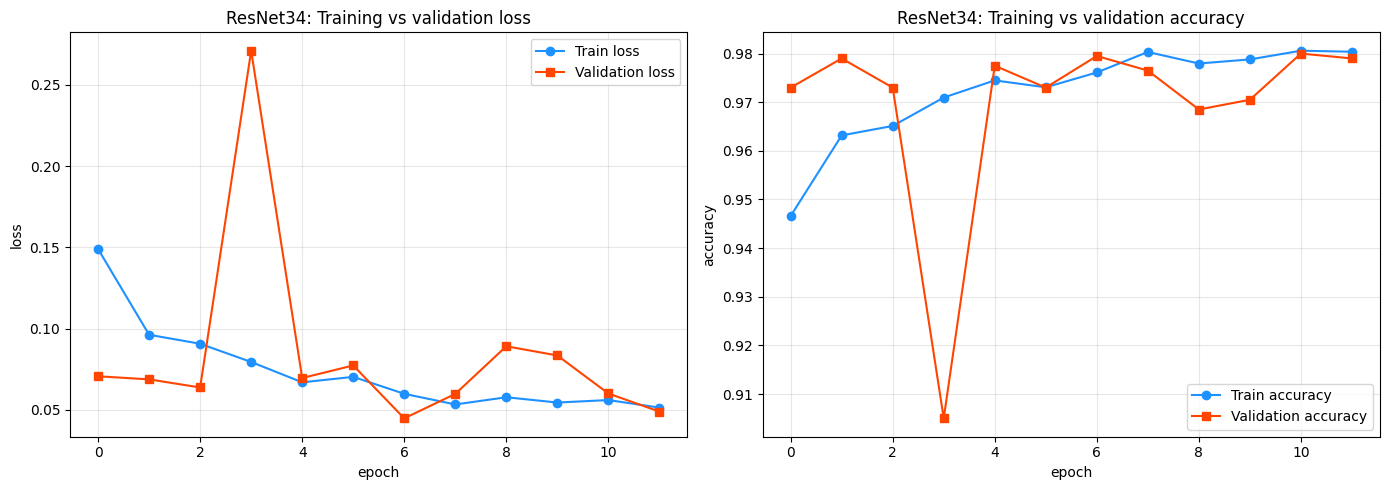

In [20]:
#Retrieve training stats for mobilenet
trainlosses = np.array([stat["trainloss"] for stat in stats_resnet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_resnet])
#Retrieve validation stats for mobilenet
vallosses = np.array([stat["valloss"] for stat in stats_resnet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_resnet])
#Retrieve epochs
epochs = np.array([stat["epoch"] for stat in stats_resnet])

#Plot training and validation curves for resnet with 2 subplots (loss and accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#Subplot 1 = loss (train and validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train loss', color='dodgerblue')
ax1.plot(epochs, vallosses, marker='s', label='Validation loss', color='orangered')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("ResNet34: Training vs validation loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

#Subplot 2 = accuracy (train and validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train accuracy', color='dodgerblue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation accuracy', color='orangered')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("ResNet34: Training vs validation accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/resnet_augmented_training_curves.png", dpi=150, bbox_inches='tight') #Save figure
plt.show()


### Visualisation of performance for ResNet34 with data augmentation with confusion matrix

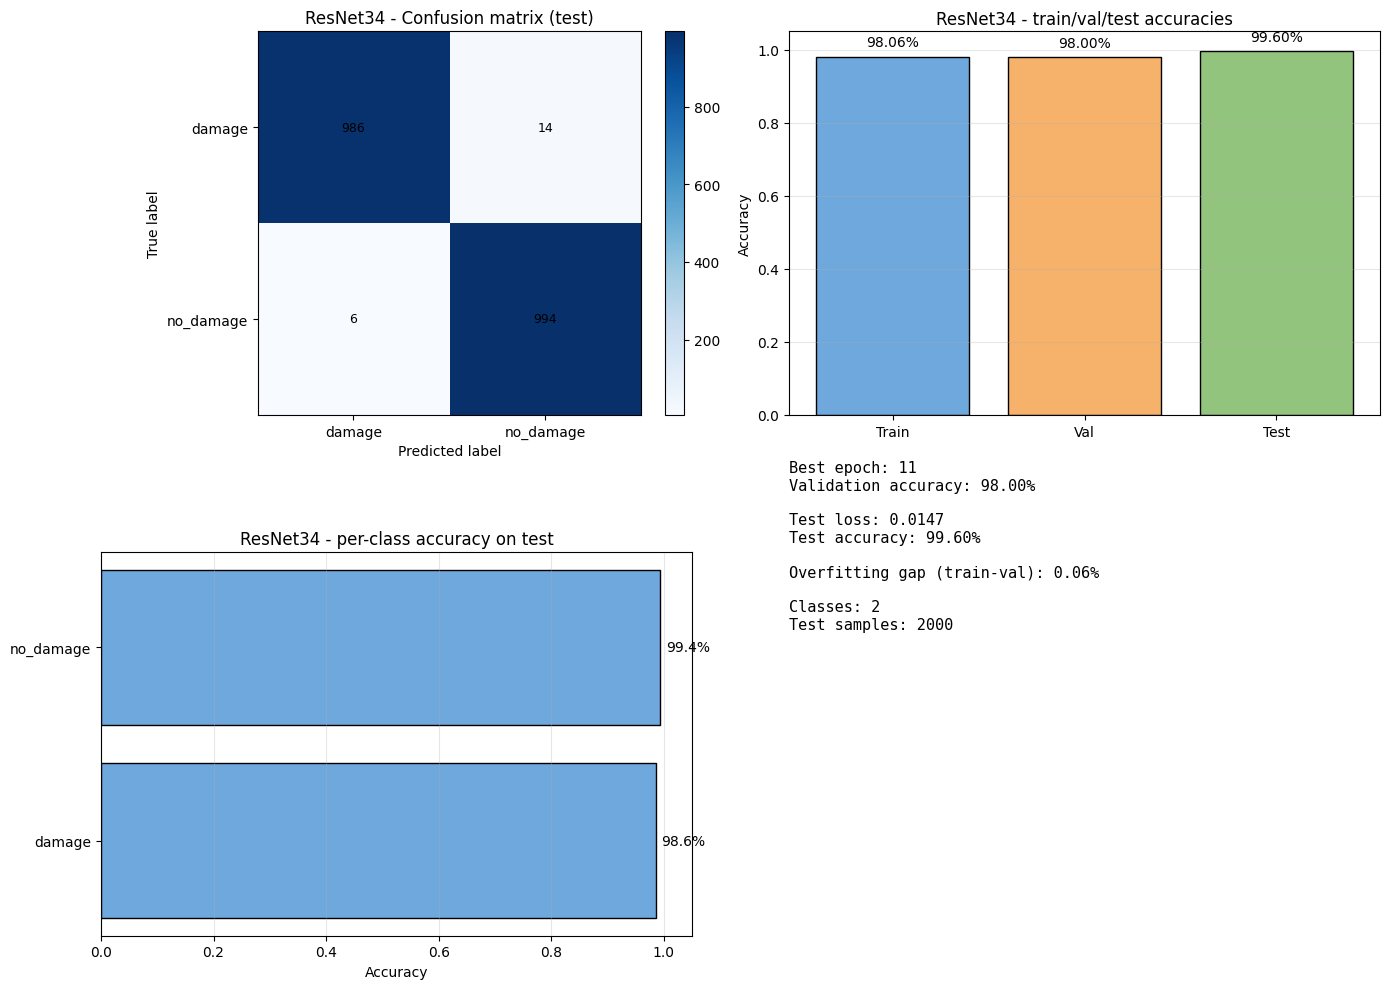

In [21]:
#Visualize detailed results for ResNet34 with data augmentation

#Retrieve predictions and true labels on the test set
all_preds_resnet, all_labels_resnet = [], []
model_resnet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y_hat = model_resnet(x)
        preds = y_hat.argmax(1)
        all_preds_resnet.append(preds.cpu())
        all_labels_resnet.append(y.cpu())

all_preds_resnet = torch.cat(all_preds_resnet).numpy()
all_labels_resnet = torch.cat(all_labels_resnet).numpy()

#Compute confusion matrix
class_names = test_ds.classes
cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet, labels=list(range(len(class_names))))
cm_norm_resnet = cm_resnet.astype(np.float64) / cm_resnet.sum(axis=1, keepdims=True)

#Compute per-class accuracy
per_class_acc_resnet = cm_resnet.diagonal() / cm_resnet.sum(axis=1)

#Retrieve key metrics
best_epoch_idx_resnet = np.argmax([stat["valaccuracy"] for stat in stats_resnet])
best_val_acc_resnet = stats_resnet[best_epoch_idx_resnet]["valaccuracy"] * 100
train_acc_best_resnet = stats_resnet[best_epoch_idx_resnet]["trainaccuracy"] * 100
val_acc_best_resnet = best_val_acc_resnet
test_acc_resnet = testaccuracy_resnet * 100
test_loss_resnet = testloss_resnet
overfit_gap_resnet = train_acc_best_resnet - val_acc_best_resnet

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Confusion matrix (counts)
im0 = axes[0, 0].imshow(cm_resnet, cmap="Blues")
axes[0, 0].set_title("ResNet34 - Confusion matrix (test)")
axes[0, 0].set_xlabel("Predicted label")
axes[0, 0].set_ylabel("True label")
axes[0, 0].set_xticks(range(len(class_names)))
axes[0, 0].set_yticks(range(len(class_names)))
axes[0, 0].set_xticklabels(class_names)
axes[0, 0].set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[0, 0].text(j, i, cm_resnet[i, j], ha="center", va="center", color="black", fontsize=9)
fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

#Barplot train / val / test accuracies
bars = axes[0, 1].bar(["Train", "Val", "Test"], [train_acc_best_resnet/100, val_acc_best_resnet/100, test_acc_resnet/100], color=["#6fa8dc", "#f6b26b", "#93c47d"], edgecolor="black")
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_title("ResNet34 - train/val/test accuracies")
for bar, acc in zip(bars, [train_acc_best_resnet, val_acc_best_resnet, test_acc_resnet]):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{acc:.2f}%", ha="center", va="bottom", fontsize=10)
axes[0, 1].grid(axis="y", alpha=0.3)

# Per-class accuracies
bars_pc = axes[1, 0].barh(class_names, per_class_acc_resnet, color="#6fa8dc", edgecolor="black")
axes[1, 0].set_xlim(0, 1.05)
axes[1, 0].set_xlabel("Accuracy")
axes[1, 0].set_title("ResNet34 - per-class accuracy on test")
for bar, acc in zip(bars_pc, per_class_acc_resnet):
    axes[1, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, f"{acc*100:.1f}%", va="center", fontsize=10)
axes[1, 0].grid(axis="x", alpha=0.3)

#Summary text
summary_text = (
    f"Best epoch: {best_epoch_idx_resnet+1}\n"
    f"Validation accuracy: {val_acc_best_resnet:.2f}%\n\n"
    f"Test loss: {test_loss_resnet:.4f}\n"
    f"Test accuracy: {test_acc_resnet:.2f}%\n\n"
    f"Overfitting gap (train-val): {overfit_gap_resnet:.2f}%\n\n"
    f"Classes: {len(class_names)}\n"
    f"Test samples: {len(all_labels_resnet)}"
)
axes[1, 1].axis("off")
axes[1, 1].text(0, 0.8, summary_text, fontsize=11, family="monospace")

plt.tight_layout()
plt.savefig("outputs/resnet_final_report.png", dpi=150, bbox_inches="tight") #Save figure
plt.show()


### F1 score for ResNet34 with data augmentation

In [22]:
# Derive F1 score, precision and recall for resnet on the test set
f1_resnet = f1_score(all_labels_resnet, all_preds_resnet, average='weighted')
precision_resnet = precision_score(all_labels_resnet, all_preds_resnet, average='weighted')
recall_resnet = recall_score(all_labels_resnet, all_preds_resnet, average='weighted')

#Display results
print(f"ResNet34: precision = {precision_resnet:.2f}  recall = {recall_resnet:.2f}  f1 = {f1_resnet:.2f}")

#Classification report for resnet
print("ResNet34 classification report:")
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=class_names))

ResNet34: precision = 0.99  recall = 0.99  f1 = 0.99
ResNet34 classification report:
              precision    recall  f1-score   support

      damage       0.99      0.99      0.99      1000
   no_damage       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



Visualisation of F1 score, recall and precision

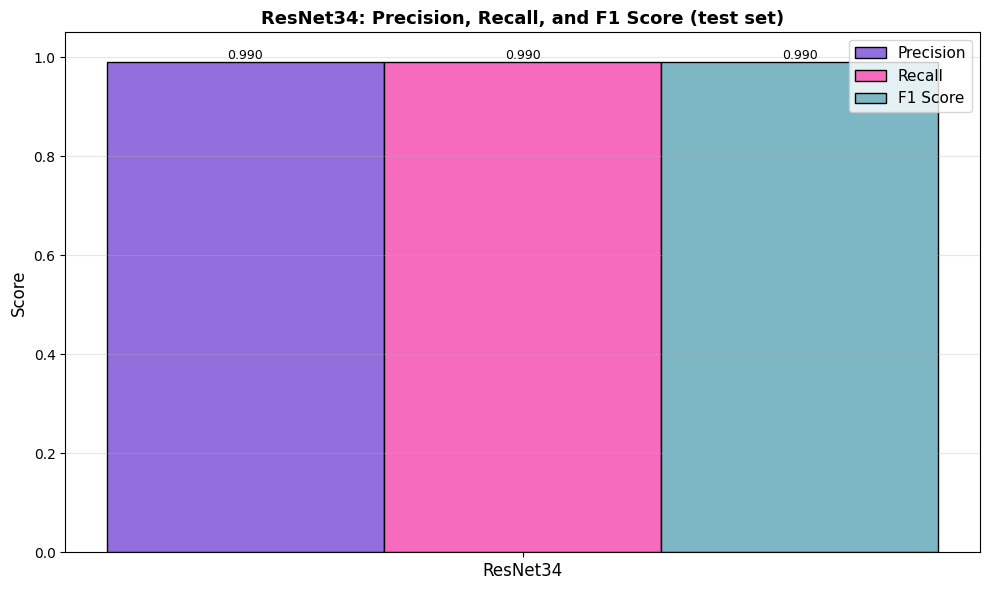

In [23]:
#Visualize F1 score, precision and recall comparison between both models
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = ['ResNet34']
f1_scores = [f1_resnet]
precisions = [precision_resnet]
recalls = [recall_resnet]

x = np.arange(len(models))
width = 0.25

bars1 = ax.bar(x - width, precisions, width, label='Precision', color="#926fdc", edgecolor='black')
bars2 = ax.bar(x, recalls, width, label='Recall', color="#f66bbe", edgecolor='black')
bars3 = ax.bar(x + width, f1_scores, width, label='F1 Score', color="#7db7c4", edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('ResNet34: Precision, Recall, and F1 Score (test set)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("outputs/f1_score_resnet34.png", dpi=150, bbox_inches='tight') #Save figure
plt.show()